# Business Understanding

Downtime for heavy machinery costs a lot of money in the manufacturing industry, both in terms of idle time wasted due to maintenance work and in terms of repair costs. It would be a significant boost to the bottom line if firms could be proactive and undertake routine maintenance activities proactively, as well as predict concerns ahead of time using previous data.
Instead, enterprises typically use IOT (Internet of Things) sensors to monitor and collect data from a variety of telemetric sensors. A predictive model can be constructed by combining telemetry data and failure reports to anticipate future heavy machinery fault occurrences.

## Business Goal

The end goal is to create a proactive maintenance strategy that tries to predict  future failures of various components in heavy machines. As mentioned earlier, it benefits the businesses by reducing operational costs, long term maintenance costs and maximizing production hours. 

## Importing Required python modules

In [15]:
# Importing required modules

import pandas as pd
import numpy as np

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# for measuring accuracy, precision, recall, f1 and auc scores
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# for model deployment
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
get_ipython().run_line_magic('matplotlib', 'inline')

from datetime import datetime as dt

# Data Understanding

The following data sources were considered for building this Predictive Maintenance Model.

* **Telemetry**: Time series data consisting of various measurements like - Voltage, Rotation, Pressure and Vibration readings from various machines.


* **Machines**: Information about machines.


* **Failures**: Records of failed components.


* **Maintenance**: Maintenance historical records of machines involving component replacements due to regular maintenance activity or due to failures. 


* **Errors**: Historical errors thrown by the machines. 

## Importing Data Sources

In [17]:
# creating data file directory
import os
##cwd = os.getcwd()
os.chdir('C:/Users/14802/OneDrive/Desktop/DSC 680-PROJECTS/Projects/Week1/Code')

cwd = os.getcwd()
print(cwd)


C:\Users\14802\OneDrive\Desktop\DSC 680-PROJECTS\Projects\Week1\Code


In [18]:
# creating data file directory
import os
cwd = os.getcwd()
print(cwd)

projdir = os.path.dirname(cwd)
datadir = os.path.join(projdir, 'Data')


# r=root, d=directories, f = files

print("\nThe directory contains below files : \n")
for r, d, f in os.walk(datadir):
    for file in f:
         print(file)


C:\Users\14802\OneDrive\Desktop\DSC 680-PROJECTS\Projects\Week1\Code

The directory contains below files : 

errors.csv
failures.csv
machines.csv
maint.csv
telemetry.csv


In [19]:
# importing telemetry data

telemetryfile = os.path.join(datadir, 'telemetry.csv')

telemetry_df = pd.read_csv(telemetryfile)
telemetry_df.head()

datetime  machineID        volt      rotate    pressure  \
0   1/1/2015 6:00:00 AM          1  176.217853  418.504078  113.077935   
1   1/1/2015 7:00:00 AM          1  162.879223  402.747490   95.460525   
2   1/1/2015 8:00:00 AM          1  170.989902  527.349825   75.237905   
3   1/1/2015 9:00:00 AM          1  162.462833  346.149335  109.248561   
4  1/1/2015 10:00:00 AM          1  157.610021  435.376873  111.886648   

   vibration  
0  45.087686  
1  43.413973  
2  34.178847  
3  41.122144  
4  25.990511

In [20]:
# importing machines data

machinesfile = os.path.join(datadir, 'machines.csv')

machines_df = pd.read_csv(machinesfile)
machines_df.head()

machineID   model  age
0          1  model3   18
1          2  model4    7
2          3  model3    8
3          4  model3    7
4          5  model3    2

In [21]:
# importing errors data

errorsfile = os.path.join(datadir, 'errors.csv')

errors_df = pd.read_csv(errorsfile)
errors_df.head()

datetime  machineID errorID
0    1/3/2015 7:00:00 AM          1  error1
1    1/3/2015 8:00:00 PM          1  error3
2    1/4/2015 6:00:00 AM          1  error5
3   1/10/2015 3:00:00 PM          1  error4
4  1/22/2015 10:00:00 AM          1  error4

In [22]:
# importing failures data

failuresfile = os.path.join(datadir, 'failures.csv')

failures_df = pd.read_csv(failuresfile)
failures_df.head()

datetime  machineID failure
0   1/5/2015 6:00:00 AM          1   comp4
1   3/6/2015 6:00:00 AM          1   comp1
2  4/20/2015 6:00:00 AM          1   comp2
3  6/19/2015 6:00:00 AM          1   comp4
4   9/2/2015 6:00:00 AM          1   comp4

In [23]:
failures_df.shape

(761, 3)

In [24]:
# importing maintenance data

maintfile = os.path.join(datadir, 'maint.csv')

maint_df = pd.read_csv(maintfile)
maint_df.head()

datetime  machineID   comp
0    6/1/2014 6:00:00 AM          1  comp2
1   7/16/2014 6:00:00 AM          1  comp4
2   7/31/2014 6:00:00 AM          1  comp3
3  12/13/2014 6:00:00 AM          1  comp1
4    1/5/2015 6:00:00 AM          1  comp4

In [25]:
# Defining fonts for plotting exploratory data analysis

titlefont = {'family': 'serif',
        'color':  'lightblue',
        'weight': 'bold',
        'size': 16,
        }

labelfont = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        }

## Exploratory Data Analysis

In [26]:
telemetry_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 876100 entries, 0 to 876099
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   datetime   876100 non-null  object 
 1   machineID  876100 non-null  int64  
 2   volt       876100 non-null  float64
 3   rotate     876100 non-null  float64
 4   pressure   876100 non-null  float64
 5   vibration  876100 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 40.1+ MB


In [27]:
telemetry_df.describe()

machineID           volt         rotate       pressure  \
count  876100.000000  876100.000000  876100.000000  876100.000000   
mean       50.500000     170.777736     446.605119     100.858668   
std        28.866087      15.509114      52.673886      11.048679   
min         1.000000      97.333604     138.432075      51.237106   
25%        25.750000     160.304927     412.305714      93.498181   
50%        50.500000     170.607338     447.558150     100.425559   
75%        75.250000     181.004493     482.176600     107.555231   
max       100.000000     255.124717     695.020984     185.951998   

           vibration  
count  876100.000000  
mean       40.385007  
std         5.370361  
min        14.877054  
25%        36.777299  
50%        40.237247  
75%        43.784938  
max        76.791072

## Checking for missing values

<AxesSubplot:>

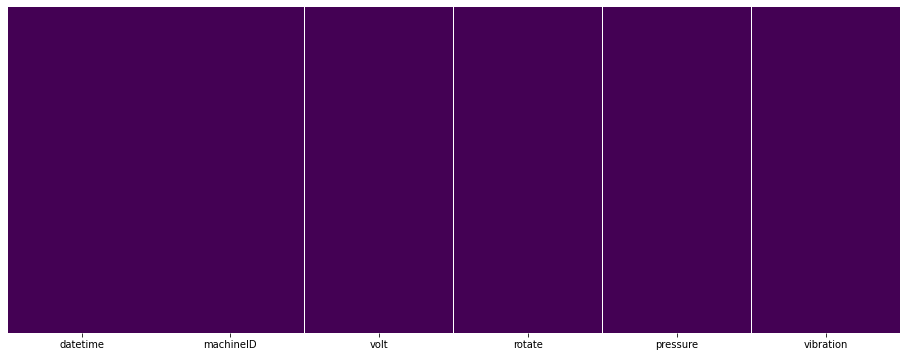

In [28]:
# checking heat map for missing values
plt.figure(figsize=(16, 6))
sns.heatmap(telemetry_df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [29]:
# Checking for blank values for each column of dataframe
telemetry_nullcols = telemetry_df.isnull().sum()
print(telemetry_nullcols)


datetime     0
machineID    0
volt         0
rotate       0
pressure     0
vibration    0
dtype: int64


In [30]:
# number of telemetry records
print(len(telemetry_df))
print(telemetry_df.shape)

876100
(876100, 6)


from datetime import datetime as dt
dt.strftime(to_datetime['datetime'])

In [31]:
telemetry_df['DT'] = pd.to_datetime(telemetry_df['datetime'])

In [32]:
# date range of telemetric data
np.min(telemetry_df['DT']), np.max(telemetry_df['DT'])

(Timestamp('2015-01-01 06:00:00'), Timestamp('2016-01-01 06:00:00'))

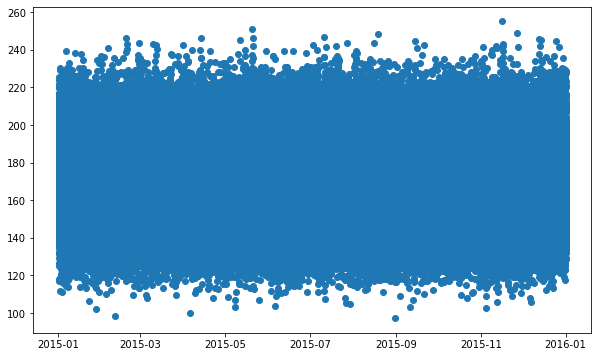

In [33]:
plt.figure(figsize=(10, 6))
plt.plot_date(x=telemetry_df['DT'], y=telemetry_df['volt'])
plt.show()

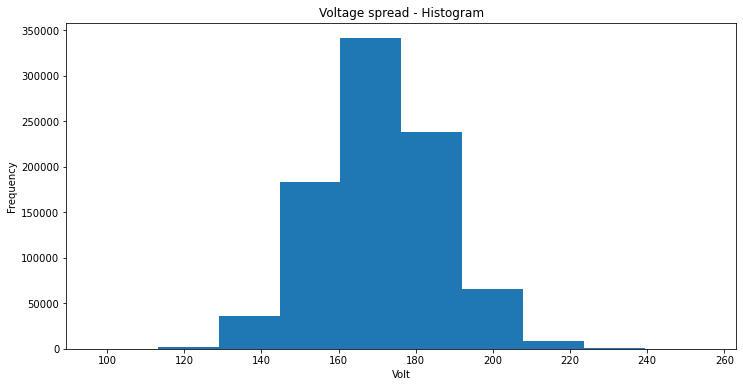

In [34]:
plt.figure(figsize=(12, 6))
plt.hist(telemetry_df['volt'])
plt.xlabel('Volt')
plt.ylabel('Frequency')
plt.title('Voltage spread - Histogram')
plt.show()

C:\Users\14802\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Voltage distribution')

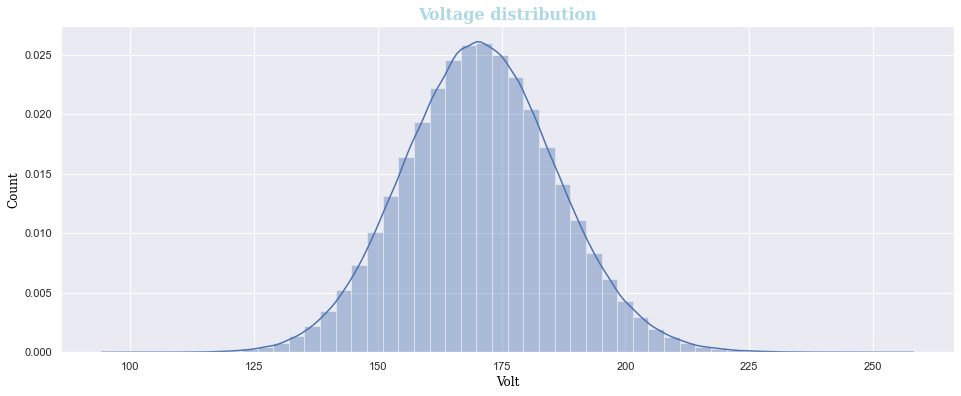

In [35]:
sns.set(style="darkgrid")
plt.figure(figsize=(16, 6))
sns.distplot(telemetry_df.volt, kde=True,color="b")

plt.xlabel("Volt", fontdict=labelfont)
plt.ylabel("Count", fontdict=labelfont)
plt.title("Voltage distribution", fontdict=titlefont)

C:\Users\14802\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Rotate distribution')

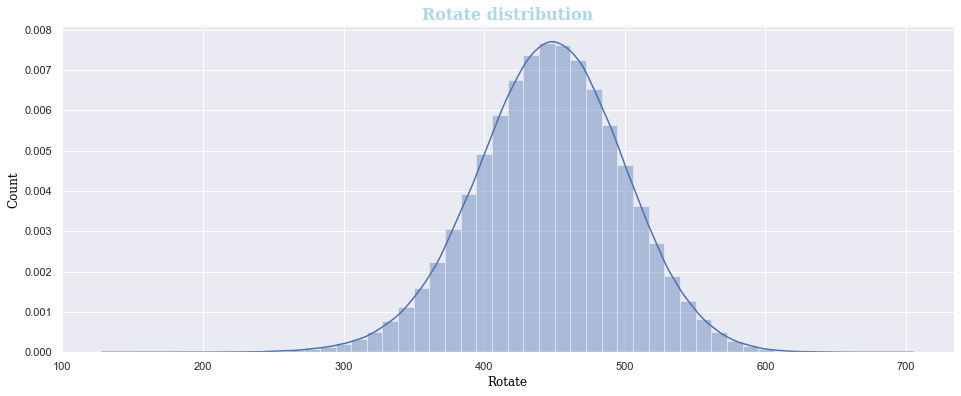

In [36]:
sns.set(style="darkgrid")
plt.figure(figsize=(16, 6))
sns.distplot(telemetry_df.rotate, kde=True,color="b")

plt.xlabel("Rotate", fontdict=labelfont)
plt.ylabel("Count", fontdict=labelfont)
plt.title("Rotate distribution", fontdict=titlefont)

C:\Users\14802\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Pressure distribution')

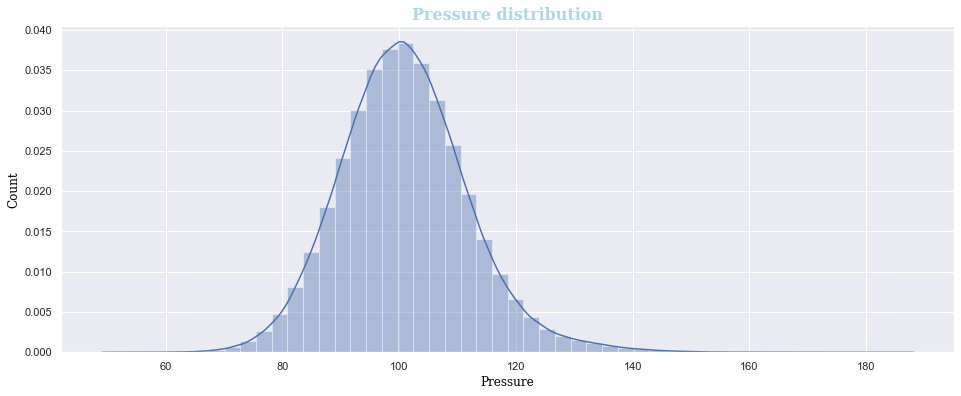

In [37]:
sns.set(style="darkgrid")
plt.figure(figsize=(16, 6))
sns.distplot(telemetry_df.pressure, kde=True,color="b")

plt.xlabel("Pressure", fontdict=labelfont)
plt.ylabel("Count", fontdict=labelfont)
plt.title("Pressure distribution", fontdict=titlefont)

C:\Users\14802\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Vibration distribution')

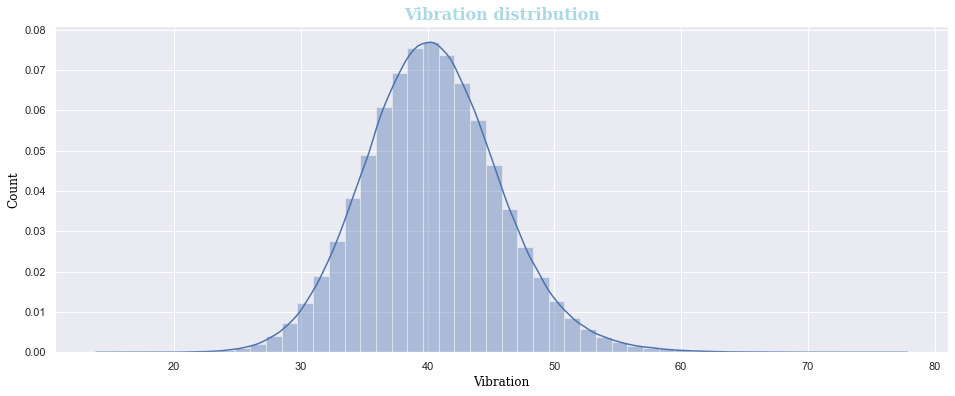

In [38]:
sns.set(style="darkgrid")
plt.figure(figsize=(16, 6))
sns.distplot(telemetry_df.vibration, kde=True,color="b")

plt.xlabel("Vibration", fontdict=labelfont)
plt.ylabel("Count", fontdict=labelfont)
plt.title("Vibration distribution", fontdict=titlefont)

In [39]:
# count of records by month

telemetry_month_df = telemetry_df[['machineID', 'DT']]
telemetry_month_df['month'] = pd.DatetimeIndex(telemetry_df['DT']).month
telemetry_month_df['yeat'] = pd.DatetimeIndex(telemetry_df['DT']).year
telemetry_month_df.head(5)


<ipython-input-39-6b6cef4bbe5f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telemetry_month_df['month'] = pd.DatetimeIndex(telemetry_df['DT']).month
<ipython-input-39-6b6cef4bbe5f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  telemetry_month_df['yeat'] = pd.DatetimeIndex(telemetry_df['DT']).year


machineID                  DT  month  yeat
0          1 2015-01-01 06:00:00      1  2015
1          1 2015-01-01 07:00:00      1  2015
2          1 2015-01-01 08:00:00      1  2015
3          1 2015-01-01 09:00:00      1  2015
4          1 2015-01-01 10:00:00      1  2015

In [40]:
telemetry_month_df2 = telemetry_month_df.groupby(['month'])['machineID'].count().reset_index()
telemetry_month_df2.head()

month  machineID
0      1      74500
1      2      67200
2      3      74400
3      4      72000
4      5      74400

Text(0.5, 1.0, 'Count of Records by Month')

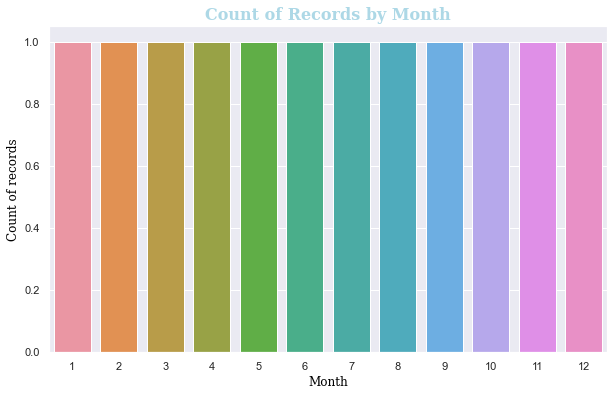

In [41]:
# Draw count plot
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="month", data=telemetry_month_df2)


plt.xlabel("Month", fontdict=labelfont)
plt.ylabel("Count of records", fontdict=labelfont)
plt.title("Count of Records by Month",fontdict=titlefont)

In [42]:
# print number of records and shape of Machines data frame
print(len(machines_df))
print(machines_df.shape)

100
(100, 3)


In [43]:
# Checking for blank values for each column of dataframe
machines_nullcols = machines_df.isnull().sum()
print(machines_nullcols)


machineID    0
model        0
age          0
dtype: int64


C:\Users\14802\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Age distribution')

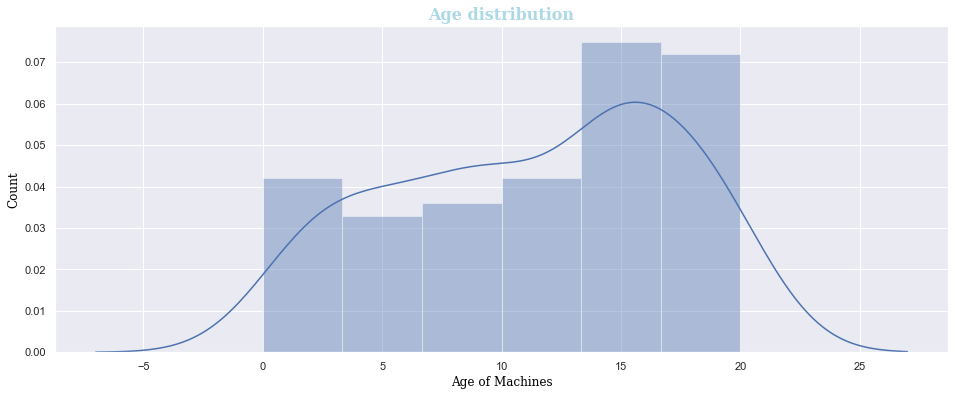

In [44]:
sns.set(style="darkgrid")
plt.figure(figsize=(16, 6))
sns.distplot(machines_df.age, kde=True,color="b")

plt.xlabel("Age of Machines", fontdict=labelfont)
plt.ylabel("Count", fontdict=labelfont)
plt.title("Age distribution", fontdict=titlefont)

In [45]:
machines_df.columns

Index(['machineID', 'model', 'age'], dtype='object')

Text(0.5, 1.0, 'Count of machines by models')

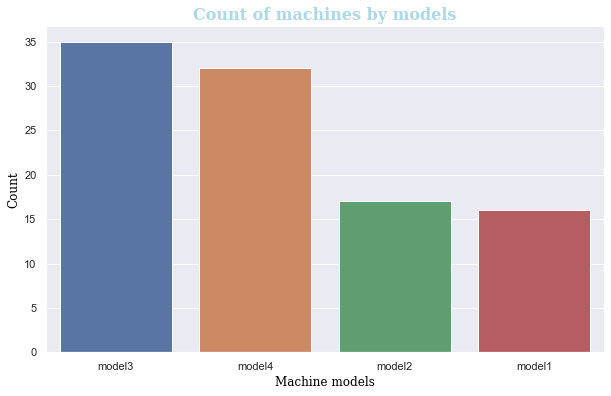

In [46]:
# Draw count plot
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="model", data=machines_df)


plt.xlabel("Machine models", fontdict=labelfont)
plt.ylabel("Count", fontdict=labelfont)
plt.title("Count of machines by models",fontdict=titlefont)

In [47]:
# print number of records and shape of Errors data frame
print(len(errors_df))
print(errors_df.shape)

3919
(3919, 3)


In [48]:
# Checking for blank values for each column of dataframe
errors_nullcols = errors_df.isnull().sum()
print(errors_nullcols)


datetime     0
machineID    0
errorID      0
dtype: int64


In [49]:
errors_df.columns

Index(['datetime', 'machineID', 'errorID'], dtype='object')

Text(0.5, 1.0, 'Count of Errors')

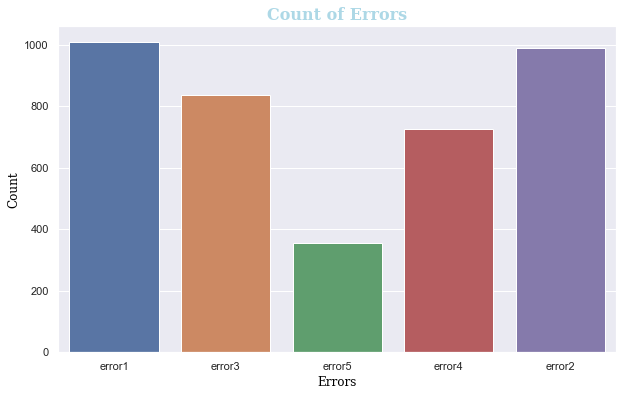

In [50]:
# Draw count plot
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="errorID", data=errors_df)


plt.xlabel("Errors", fontdict=labelfont)
plt.ylabel("Count", fontdict=labelfont)
plt.title("Count of Errors",fontdict=titlefont)

In [51]:
# print number of records and shape of Failure data frame
print(len(failures_df))
print(failures_df.shape)

761
(761, 3)


In [52]:
# Checking for blank values for each column of dataframe
failures_nullcols = failures_df.isnull().sum()
print(failures_nullcols)


datetime     0
machineID    0
failure      0
dtype: int64


In [53]:
failures_df.columns

Index(['datetime', 'machineID', 'failure'], dtype='object')

Text(0.5, 1.0, 'Count of Failures')

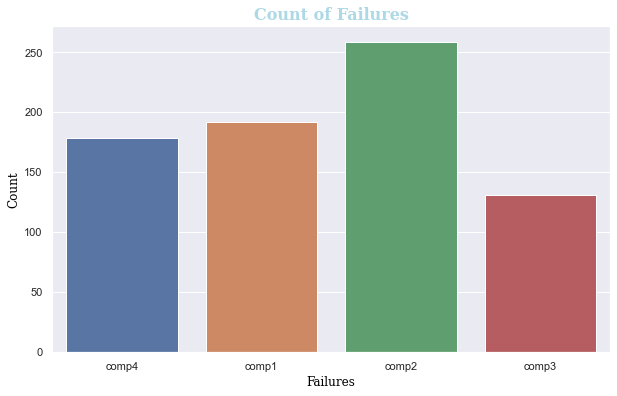

In [54]:
# Draw count plot
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="failure", data=failures_df)


plt.xlabel("Failures", fontdict=labelfont)
plt.ylabel("Count", fontdict=labelfont)
plt.title("Count of Failures",fontdict=titlefont)

In [55]:
# print number of records and shape of Maintenance data frame
print(len(maint_df))
print(maint_df.shape)

3286
(3286, 3)


In [56]:
# Checking for blank values for each column of dataframe
maint_nullcols = maint_df.isnull().sum()
print(maint_nullcols)


datetime     0
machineID    0
comp         0
dtype: int64


In [57]:
maint_df.columns

Index(['datetime', 'machineID', 'comp'], dtype='object')

Text(0.5, 1.0, 'Count of Components')

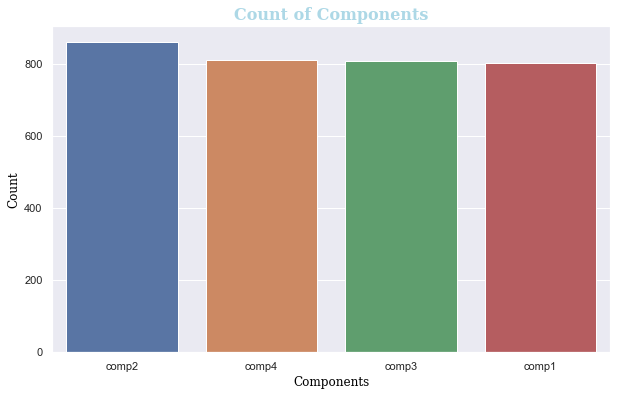

In [58]:
# Draw count plot
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
ax = sns.countplot(x="comp", data=maint_df)


plt.xlabel("Components", fontdict=labelfont)
plt.ylabel("Count", fontdict=labelfont)
plt.title("Count of Components",fontdict=titlefont)

# Data Preparation

## Feature Engineering

In [59]:
# converting all date time fields into Date Time Format

errors_df['DT'] = pd.to_datetime(errors_df['datetime'])
failures_df['DT'] = pd.to_datetime(failures_df['datetime'])
maint_df['DT'] = pd.to_datetime(maint_df['datetime'])


In [60]:
telemetry_df.columns

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'DT'],
      dtype='object')

for dt in telemetry_df['DT']:
    print(dt.strftime("%X"))

In [61]:
telemetry_df['time'] = [dt.strftime("%H") for dt in telemetry_df['DT']]
telemetry_df.head(5)

datetime  machineID        volt      rotate    pressure  \
0   1/1/2015 6:00:00 AM          1  176.217853  418.504078  113.077935   
1   1/1/2015 7:00:00 AM          1  162.879223  402.747490   95.460525   
2   1/1/2015 8:00:00 AM          1  170.989902  527.349825   75.237905   
3   1/1/2015 9:00:00 AM          1  162.462833  346.149335  109.248561   
4  1/1/2015 10:00:00 AM          1  157.610021  435.376873  111.886648   

   vibration                  DT time  
0  45.087686 2015-01-01 06:00:00   06  
1  43.413973 2015-01-01 07:00:00   07  
2  34.178847 2015-01-01 08:00:00   08  
3  41.122144 2015-01-01 09:00:00   09  
4  25.990511 2015-01-01 10:00:00   10

In [62]:
 for time in telemetry_df['time'][0:5]:
        print(type(int(time)))

<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [63]:
telemetry_df['hrbucket'] = [(int(time) // 3) for time in telemetry_df['time'] ]
telemetry_df.head(5)

datetime  machineID        volt      rotate    pressure  \
0   1/1/2015 6:00:00 AM          1  176.217853  418.504078  113.077935   
1   1/1/2015 7:00:00 AM          1  162.879223  402.747490   95.460525   
2   1/1/2015 8:00:00 AM          1  170.989902  527.349825   75.237905   
3   1/1/2015 9:00:00 AM          1  162.462833  346.149335  109.248561   
4  1/1/2015 10:00:00 AM          1  157.610021  435.376873  111.886648   

   vibration                  DT time  hrbucket  
0  45.087686 2015-01-01 06:00:00   06         2  
1  43.413973 2015-01-01 07:00:00   07         2  
2  34.178847 2015-01-01 08:00:00   08         2  
3  41.122144 2015-01-01 09:00:00   09         3  
4  25.990511 2015-01-01 10:00:00   10         3

In [64]:
#telemetry_df['weekday'] = [dt.weekday() for dt in telemetry_df['DT']]
telemetry_df['weekday'] = [dt.strftime("%A") for dt in telemetry_df['DT']]
telemetry_df['date'] = [dt.strftime("%x") for dt in telemetry_df['DT']]
telemetry_df.head(5)

datetime  machineID        volt      rotate    pressure  \
0   1/1/2015 6:00:00 AM          1  176.217853  418.504078  113.077935   
1   1/1/2015 7:00:00 AM          1  162.879223  402.747490   95.460525   
2   1/1/2015 8:00:00 AM          1  170.989902  527.349825   75.237905   
3   1/1/2015 9:00:00 AM          1  162.462833  346.149335  109.248561   
4  1/1/2015 10:00:00 AM          1  157.610021  435.376873  111.886648   

   vibration                  DT time  hrbucket   weekday      date  
0  45.087686 2015-01-01 06:00:00   06         2  Thursday  01/01/15  
1  43.413973 2015-01-01 07:00:00   07         2  Thursday  01/01/15  
2  34.178847 2015-01-01 08:00:00   08         2  Thursday  01/01/15  
3  41.122144 2015-01-01 09:00:00   09         3  Thursday  01/01/15  
4  25.990511 2015-01-01 10:00:00   10         3  Thursday  01/01/15

In [65]:
# grouping data by machineID, date and hrbucket calculating mean of metrics

telemetry_df2 = telemetry_df.groupby(['machineID','date', 'hrbucket']).aggregate({'DT': 'max',
                                                                                'volt': 'mean',
                                                                                'rotate': 'mean',
                                                                                'pressure': 'mean',
                                                                                'vibration': 'mean',
                                                                                'volt': 'std',
                                                                                'rotate': 'std',
                                                                                'pressure': 'std',
                                                                                'vibration': 'std'
                                                                                   })

telemetry_df2.head()

DT       volt     rotate  \
machineID date     hrbucket                                             
1         01/01/15 2        2015-01-01 08:00:00   6.721032  67.849599   
                   3        2015-01-01 11:00:00   7.596570  50.120452   
                   4        2015-01-01 14:00:00  10.124584  55.084734   
                   5        2015-01-01 17:00:00   4.673269  42.047278   
                   6        2015-01-01 20:00:00  14.752132  47.048609   

                              pressure  vibration  
machineID date     hrbucket                        
1         01/01/15 2         18.934956   5.874970  
                   3          8.555032   7.662229  
                   4          5.909721   5.169304  
                   5          4.554047   2.106108  
                   6          4.244158   2.207884

In [66]:
# grouping data by machineID, date and hrbucket calculating mean of metrics

telemetry_df2 = telemetry_df.groupby(['machineID','date', 'hrbucket']).aggregate({'DT': 'max',
                                                                                'volt': ('mean','std'),
                                                                                'rotate': ('mean','std'),
                                                                                'pressure': ('mean','std'),
                                                                                'vibration': ('mean','std')
                                                                                 }).reset_index()

telemetry_df2.head()

machineID      date hrbucket                  DT        volt             \
                                               max        mean        std   
0         1  01/01/15        2 2015-01-01 08:00:00  170.028993   6.721032   
1         1  01/01/15        3 2015-01-01 11:00:00  164.192565   7.596570   
2         1  01/01/15        4 2015-01-01 14:00:00  168.134445  10.124584   
3         1  01/01/15        5 2015-01-01 17:00:00  165.514453   4.673269   
4         1  01/01/15        6 2015-01-01 20:00:00  168.809347  14.752132   

       rotate               pressure             vibration            
         mean        std        mean        std       mean       std  
0  449.533798  67.849599   94.592122  18.934956  40.893502  5.874970  
1  403.949857  50.120452  105.687417   8.555032  34.255891  7.662229  
2  435.781707  55.084734  107.793709   5.909721  41.239405  5.169304  
3  430.472823  42.047278  101.703289   4.554047  40.373739  2.106108  
4  437.111120  47.048609   90.911060   4.244158  41.738542  2.207884

In [67]:
# grouping data by machineID, date and hrbucket calculating mean of metrics

telemetry_df2 = telemetry_df.groupby(['machineID','date', 'hrbucket']).aggregate({'DT': 'max',
                                                                                'volt': ('mean','std'),
                                                                                'rotate': ('mean','std'),
                                                                                'pressure': ('mean','std'),
                                                                                'vibration': ('mean','std')
                                                                                 }).reset_index()

telemetry_df2.head()

machineID      date hrbucket                  DT        volt             \
                                               max        mean        std   
0         1  01/01/15        2 2015-01-01 08:00:00  170.028993   6.721032   
1         1  01/01/15        3 2015-01-01 11:00:00  164.192565   7.596570   
2         1  01/01/15        4 2015-01-01 14:00:00  168.134445  10.124584   
3         1  01/01/15        5 2015-01-01 17:00:00  165.514453   4.673269   
4         1  01/01/15        6 2015-01-01 20:00:00  168.809347  14.752132   

       rotate               pressure             vibration            
         mean        std        mean        std       mean       std  
0  449.533798  67.849599   94.592122  18.934956  40.893502  5.874970  
1  403.949857  50.120452  105.687417   8.555032  34.255891  7.662229  
2  435.781707  55.084734  107.793709   5.909721  41.239405  5.169304  
3  430.472823  42.047278  101.703289   4.554047  40.373739  2.106108  
4  437.111120  47.048609   90.911060   4.244158  41.738542  2.207884

In [68]:
# grouping data by machineID, date and hrbucket calculating mean of metrics

telemetry_df2 = telemetry_df.groupby(['machineID','date', 'hrbucket'])\
                            .agg({ 'DT' : [('m_DT', 'max')],
                                  'volt' : [('m_volt','mean'), ('sd_volt','std')],
                                  'rotate' : [('m_rotate','mean'), ('sd_rotate','std')],
                                  'pressure' : [('m_pressure','mean'), ('sd_pressure','std')],
                                   'vibration' : [('m_vibration','mean'), ('sd_vibration','std')],
                                   }).reset_index()

telemetry_df2.head()

machineID      date hrbucket                  DT        volt             \
                                              m_DT      m_volt    sd_volt   
0         1  01/01/15        2 2015-01-01 08:00:00  170.028993   6.721032   
1         1  01/01/15        3 2015-01-01 11:00:00  164.192565   7.596570   
2         1  01/01/15        4 2015-01-01 14:00:00  168.134445  10.124584   
3         1  01/01/15        5 2015-01-01 17:00:00  165.514453   4.673269   
4         1  01/01/15        6 2015-01-01 20:00:00  168.809347  14.752132   

       rotate               pressure               vibration               
     m_rotate  sd_rotate  m_pressure sd_pressure m_vibration sd_vibration  
0  449.533798  67.849599   94.592122   18.934956   40.893502     5.874970  
1  403.949857  50.120452  105.687417    8.555032   34.255891     7.662229  
2  435.781707  55.084734  107.793709    5.909721   41.239405     5.169304  
3  430.472823  42.047278  101.703289    4.554047   40.373739     2.106108  
4  437.111120  47.048609   90.911060    4.244158   41.738542     2.207884

In [69]:
telemetry_df2.columns

MultiIndex([('machineID',             ''),
            (     'date',             ''),
            ( 'hrbucket',             ''),
            (       'DT',         'm_DT'),
            (     'volt',       'm_volt'),
            (     'volt',      'sd_volt'),
            (   'rotate',     'm_rotate'),
            (   'rotate',    'sd_rotate'),
            ( 'pressure',   'm_pressure'),
            ( 'pressure',  'sd_pressure'),
            ('vibration',  'm_vibration'),
            ('vibration', 'sd_vibration')],
           )

In [70]:
telemetry_df2.columns = telemetry_df2.columns.get_level_values(0)
telemetry_df2.columns = ['machineID', 'date', 'hrbucket', 'DT', 'm_volt', 'sd_volt', 'm_rotate',
       'sd_rotate', 'm_pressure', 'sd_pressure', 'm_vibration', 'sd_vibration']

In [71]:
telemetry_df2.head()

machineID      date  hrbucket                  DT      m_volt    sd_volt  \
0          1  01/01/15         2 2015-01-01 08:00:00  170.028993   6.721032   
1          1  01/01/15         3 2015-01-01 11:00:00  164.192565   7.596570   
2          1  01/01/15         4 2015-01-01 14:00:00  168.134445  10.124584   
3          1  01/01/15         5 2015-01-01 17:00:00  165.514453   4.673269   
4          1  01/01/15         6 2015-01-01 20:00:00  168.809347  14.752132   

     m_rotate  sd_rotate  m_pressure  sd_pressure  m_vibration  sd_vibration  
0  449.533798  67.849599   94.592122    18.934956    40.893502      5.874970  
1  403.949857  50.120452  105.687417     8.555032    34.255891      7.662229  
2  435.781707  55.084734  107.793709     5.909721    41.239405      5.169304  
3  430.472823  42.047278  101.703289     4.554047    40.373739      2.106108  
4  437.111120  47.048609   90.911060     4.244158    41.738542      2.207884

## Calculate mean and standard deviation of metrics for a rolling 24 hour windows

In [72]:
volt_mean_24 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='volt').rolling(window=24).mean().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()

print(type(volt_mean_24))

<class 'pandas.core.series.Series'>


In [73]:
volt_std_24 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='volt').rolling(window=24).std().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()

print(type(volt_std_24))

<class 'pandas.core.series.Series'>


In [74]:
rotate_mean_24 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='rotate').rolling(window=24).mean().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()


rotate_std_24 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='rotate').rolling(window=24).std().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()



In [75]:
pressure_mean_24 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='pressure').rolling(window=24).mean().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()


pressure_std_24 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='pressure').rolling(window=24).std().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()



In [76]:
vibration_mean_24 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='vibration').rolling(window=24).mean().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()


vibration_std_24 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='vibration').rolling(window=24).std().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()



In [77]:
list_24hrs = [volt_mean_24, volt_std_24, rotate_mean_24 ,rotate_std_24 , pressure_mean_24, pressure_std_24, vibration_mean_24, vibration_std_24]
telemetry_24df = pd.concat(list_24hrs, axis=1 )
telemetry_24df.head(10)

0          1           2          3  \
machineID DT                                                                  
1         2015-01-01 09:00:00         NaN        NaN         NaN        NaN   
          2015-01-01 12:00:00         NaN        NaN         NaN        NaN   
          2015-01-01 15:00:00         NaN        NaN         NaN        NaN   
          2015-01-01 18:00:00         NaN        NaN         NaN        NaN   
          2015-01-01 21:00:00         NaN        NaN         NaN        NaN   
          2015-01-02 00:00:00         NaN        NaN         NaN        NaN   
          2015-01-02 03:00:00         NaN        NaN         NaN        NaN   
          2015-01-02 06:00:00  169.733809  11.233120  445.179865  48.717395   
          2015-01-02 09:00:00  170.614862  12.519402  446.364859  48.385076   
          2015-01-02 12:00:00  169.893965  13.370357  447.009407  42.432317   

                                       4          5          6         7  
machineID DT                                                              
1         2015-01-01 09:00:00        NaN        NaN        NaN       NaN  
          2015-01-01 12:00:00        NaN        NaN        NaN       NaN  
          2015-01-01 15:00:00        NaN        NaN        NaN       NaN  
          2015-01-01 18:00:00        NaN        NaN        NaN       NaN  
          2015-01-01 21:00:00        NaN        NaN        NaN       NaN  
          2015-01-02 00:00:00        NaN        NaN        NaN       NaN  
          2015-01-02 03:00:00        NaN        NaN        NaN       NaN  
          2015-01-02 06:00:00  96.797113  10.079880  40.385160  5.853209  
          2015-01-02 09:00:00  96.849785  10.171540  39.736826  6.163231  
          2015-01-02 12:00:00  97.715600   9.471669  39.498374  6.195076

In [78]:
telemetry_24df.columns

RangeIndex(start=0, stop=8, step=1)

In [79]:
telemetry_24df.columns = ['volt_mean_24', 'volt_std_24', 'rotate_mean_24' ,'rotate_std_24','pressure_mean_24', 
                          'pressure_std_24', 'vibration_mean_24', 'vibration_std_24']
telemetry_24df = telemetry_24df.reset_index()
telemetry_24df.head(10)

machineID                  DT  volt_mean_24  volt_std_24  rotate_mean_24  \
0          1 2015-01-01 09:00:00           NaN          NaN             NaN   
1          1 2015-01-01 12:00:00           NaN          NaN             NaN   
2          1 2015-01-01 15:00:00           NaN          NaN             NaN   
3          1 2015-01-01 18:00:00           NaN          NaN             NaN   
4          1 2015-01-01 21:00:00           NaN          NaN             NaN   
5          1 2015-01-02 00:00:00           NaN          NaN             NaN   
6          1 2015-01-02 03:00:00           NaN          NaN             NaN   
7          1 2015-01-02 06:00:00    169.733809    11.233120      445.179865   
8          1 2015-01-02 09:00:00    170.614862    12.519402      446.364859   
9          1 2015-01-02 12:00:00    169.893965    13.370357      447.009407   

   rotate_std_24  pressure_mean_24  pressure_std_24  vibration_mean_24  \
0            NaN               NaN              NaN                NaN   
1            NaN               NaN              NaN                NaN   
2            NaN               NaN              NaN                NaN   
3            NaN               NaN              NaN                NaN   
4            NaN               NaN              NaN                NaN   
5            NaN               NaN              NaN                NaN   
6            NaN               NaN              NaN                NaN   
7      48.717395         96.797113        10.079880          40.385160   
8      48.385076         96.849785        10.171540          39.736826   
9      42.432317         97.715600         9.471669          39.498374   

   vibration_std_24  
0               NaN  
1               NaN  
2               NaN  
3               NaN  
4               NaN  
5               NaN  
6               NaN  
7          5.853209  
8          6.163231  
9          6.195076

In [80]:
volt_mean_3 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='volt').rolling(window=3).mean().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()

volt_std_3 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='volt').rolling(window=3).std().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()

rotate_mean_3 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='rotate').rolling(window=3).mean().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()


rotate_std_3 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='rotate').rolling(window=3).std().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()

pressure_mean_3 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='pressure').rolling(window=3).mean().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()


pressure_std_3 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='pressure').rolling(window=3).std().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()


vibration_mean_3 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='vibration').rolling(window=3).mean().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()


vibration_std_3 = pd.pivot_table(telemetry_df,
                               index='DT',
                               columns='machineID',
                               values='vibration').rolling(window=3).std().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()


In [81]:
list_3hrs = [volt_mean_3, volt_std_3, rotate_mean_3,rotate_std_3, pressure_mean_3, pressure_std_3, 
             vibration_mean_3, vibration_std_3]
telemetry_3df = pd.concat(list_3hrs, axis=1 )
telemetry_3df.head(10)

0          1           2          3  \
machineID DT                                                                  
1         2015-01-01 09:00:00  170.028993   6.721032  449.533798  67.849599   
          2015-01-01 12:00:00  165.443986   4.807415  425.415550  92.702671   
          2015-01-01 15:00:00  162.223630   8.919370  454.923953  38.316408   
          2015-01-01 18:00:00  172.355243   3.056496  423.041389  33.200513   
          2015-01-01 21:00:00  160.226142   6.853823  440.413573  54.501054   
          2015-01-02 00:00:00  178.513887   7.084050  440.859804  53.461091   
          2015-01-02 03:00:00  167.989524  14.910036  481.173775  33.823675   
          2015-01-02 06:00:00  165.002124   5.959072  456.438211  54.613403   
          2015-01-02 09:00:00  193.164359  10.459846  448.652619  46.294659   
          2015-01-02 12:00:00  159.676811  11.972868  430.571937  51.632304   

                                        4          5          6          7  
machineID DT                                                                
1         2015-01-01 09:00:00   94.592122  18.934956  40.893502   5.874970  
          2015-01-01 12:00:00   93.315664  17.106476  39.571655   4.808836  
          2015-01-01 15:00:00  106.523125   9.176711  34.799816   8.414362  
          2015-01-01 18:00:00  105.491224   4.843754  40.288677   5.011355  
          2015-01-01 21:00:00   95.424693   8.931082  41.776012   2.889493  
          2015-01-02 00:00:00   90.827785   4.388335  44.042853   6.098198  
          2015-01-02 03:00:00   94.103572   2.705111  37.755087   5.033474  
          2015-01-02 06:00:00   87.673270   7.623486  41.527048   2.704438  
          2015-01-02 09:00:00  101.438946  11.281152  38.133459  12.407322  
          2015-01-02 12:00:00  100.242184  12.041639  37.664039   4.682870

In [82]:
telemetry_3df.columns = ['volt_mean_3', 'volt_std_3', 'rotate_mean_3' ,'rotate_std_3','pressure_mean_3', 
                          'pressure_std_3', 'vibration_mean_3', 'vibration_std_3']
telemetry_3df = telemetry_3df.reset_index()
telemetry_3df.head(10)

machineID                  DT  volt_mean_3  volt_std_3  rotate_mean_3  \
0          1 2015-01-01 09:00:00   170.028993    6.721032     449.533798   
1          1 2015-01-01 12:00:00   165.443986    4.807415     425.415550   
2          1 2015-01-01 15:00:00   162.223630    8.919370     454.923953   
3          1 2015-01-01 18:00:00   172.355243    3.056496     423.041389   
4          1 2015-01-01 21:00:00   160.226142    6.853823     440.413573   
5          1 2015-01-02 00:00:00   178.513887    7.084050     440.859804   
6          1 2015-01-02 03:00:00   167.989524   14.910036     481.173775   
7          1 2015-01-02 06:00:00   165.002124    5.959072     456.438211   
8          1 2015-01-02 09:00:00   193.164359   10.459846     448.652619   
9          1 2015-01-02 12:00:00   159.676811   11.972868     430.571937   

   rotate_std_3  pressure_mean_3  pressure_std_3  vibration_mean_3  \
0     67.849599        94.592122       18.934956         40.893502   
1     92.702671        93.315664       17.106476         39.571655   
2     38.316408       106.523125        9.176711         34.799816   
3     33.200513       105.491224        4.843754         40.288677   
4     54.501054        95.424693        8.931082         41.776012   
5     53.461091        90.827785        4.388335         44.042853   
6     33.823675        94.103572        2.705111         37.755087   
7     54.613403        87.673270        7.623486         41.527048   
8     46.294659       101.438946       11.281152         38.133459   
9     51.632304       100.242184       12.041639         37.664039   

   vibration_std_3  
0         5.874970  
1         4.808836  
2         8.414362  
3         5.011355  
4         2.889493  
5         6.098198  
6         5.033474  
7         2.704438  
8        12.407322  
9         4.682870

In [83]:
# creating combined data set of summarized data
telemetry_summarydf = pd.merge(telemetry_3df,telemetry_24df, left_on = ['machineID','DT'], 
                        right_on = ['machineID','DT'], how='left').fillna(0)

telemetry_summarydf.head(10)

machineID                  DT  volt_mean_3  volt_std_3  rotate_mean_3  \
0          1 2015-01-01 09:00:00   170.028993    6.721032     449.533798   
1          1 2015-01-01 12:00:00   165.443986    4.807415     425.415550   
2          1 2015-01-01 15:00:00   162.223630    8.919370     454.923953   
3          1 2015-01-01 18:00:00   172.355243    3.056496     423.041389   
4          1 2015-01-01 21:00:00   160.226142    6.853823     440.413573   
5          1 2015-01-02 00:00:00   178.513887    7.084050     440.859804   
6          1 2015-01-02 03:00:00   167.989524   14.910036     481.173775   
7          1 2015-01-02 06:00:00   165.002124    5.959072     456.438211   
8          1 2015-01-02 09:00:00   193.164359   10.459846     448.652619   
9          1 2015-01-02 12:00:00   159.676811   11.972868     430.571937   

   rotate_std_3  pressure_mean_3  pressure_std_3  vibration_mean_3  \
0     67.849599        94.592122       18.934956         40.893502   
1     92.702671        93.315664       17.106476         39.571655   
2     38.316408       106.523125        9.176711         34.799816   
3     33.200513       105.491224        4.843754         40.288677   
4     54.501054        95.424693        8.931082         41.776012   
5     53.461091        90.827785        4.388335         44.042853   
6     33.823675        94.103572        2.705111         37.755087   
7     54.613403        87.673270        7.623486         41.527048   
8     46.294659       101.438946       11.281152         38.133459   
9     51.632304       100.242184       12.041639         37.664039   

   vibration_std_3  volt_mean_24  volt_std_24  rotate_mean_24  rotate_std_24  \
0         5.874970      0.000000     0.000000        0.000000       0.000000   
1         4.808836      0.000000     0.000000        0.000000       0.000000   
2         8.414362      0.000000     0.000000        0.000000       0.000000   
3         5.011355      0.000000     0.000000        0.000000       0.000000   
4         2.889493      0.000000     0.000000        0.000000       0.000000   
5         6.098198      0.000000     0.000000        0.000000       0.000000   
6         5.033474      0.000000     0.000000        0.000000       0.000000   
7         2.704438    169.733809    11.233120      445.179865      48.717395   
8        12.407322    170.614862    12.519402      446.364859      48.385076   
9         4.682870    169.893965    13.370357      447.009407      42.432317   

   pressure_mean_24  pressure_std_24  vibration_mean_24  vibration_std_24  
0          0.000000         0.000000           0.000000          0.000000  
1          0.000000         0.000000           0.000000          0.000000  
2          0.000000         0.000000           0.000000          0.000000  
3          0.000000         0.000000           0.000000          0.000000  
4          0.000000         0.000000           0.000000          0.000000  
5          0.000000         0.000000           0.000000          0.000000  
6          0.000000         0.000000           0.000000          0.000000  
7         96.797113        10.079880          40.385160          5.853209  
8         96.849785        10.171540          39.736826          6.163231  
9         97.715600         9.471669          39.498374          6.195076

## Creating summary data for errors_df

In [84]:
errors_df.columns

Index(['datetime', 'machineID', 'errorID', 'DT'], dtype='object')

In [85]:
# grouping data by machineID, date and hrbucket calculating mean of metrics

errorcounts_df = errors_df.groupby(['machineID','DT', 'errorID'])\
                            .agg({ 'errorID' : [('count','count')]
                                   }).reset_index()

errorcounts_df.head()

machineID                  DT errorID      
                                        count
0         1 2015-01-03 07:00:00  error1     1
1         1 2015-01-03 20:00:00  error3     1
2         1 2015-01-04 06:00:00  error5     1
3         1 2015-01-10 15:00:00  error4     1
4         1 2015-01-22 10:00:00  error4     1

In [86]:
errorcounts_df.columns = errorcounts_df.columns.get_level_values(0)
errorcounts_df.columns = ['machineID', 'DT', 'errorID', 'errorcount']

In [87]:
errorcounts_ctdf = pd.crosstab([errorcounts_df.machineID, errorcounts_df.DT], errorcounts_df.errorID).reset_index()
errorcounts_ctdf = errorcounts_ctdf.sort_values('DT')
errorcounts_ctdf.head()

errorID  machineID                  DT  error1  error2  error3  error4  error5
2874            81 2015-01-01 06:00:00       1       0       0       0       0
836             24 2015-01-01 06:00:00       1       0       0       0       0
2579            73 2015-01-01 06:00:00       0       0       0       1       0
1497            43 2015-01-01 07:00:00       0       0       1       0       0
2683            76 2015-01-01 08:00:00       0       0       0       0       1

In [88]:
print(len(errorcounts_ctdf))

3616


In [89]:
# joining error and telemetry data based on date time and machine ID
telemetry_dts = telemetry_df[['machineID','DT']]
telemetry_dts.head(5)



machineID                  DT
0          1 2015-01-01 06:00:00
1          1 2015-01-01 07:00:00
2          1 2015-01-01 08:00:00
3          1 2015-01-01 09:00:00
4          1 2015-01-01 10:00:00

In [90]:
errorcounts_dtdf = pd.merge(telemetry_dts,errorcounts_ctdf, left_on = ['machineID','DT'], 
                        right_on = ['machineID','DT'], how='left').fillna(0)

errorcounts_dtdf.head(5)

machineID                  DT  error1  error2  error3  error4  error5
0          1 2015-01-01 06:00:00     0.0     0.0     0.0     0.0     0.0
1          1 2015-01-01 07:00:00     0.0     0.0     0.0     0.0     0.0
2          1 2015-01-01 08:00:00     0.0     0.0     0.0     0.0     0.0
3          1 2015-01-01 09:00:00     0.0     0.0     0.0     0.0     0.0
4          1 2015-01-01 10:00:00     0.0     0.0     0.0     0.0     0.0

In [91]:
# summarize the errors for every 3 hours to includes errors occured in the last 24 hours

error1_count = pd.pivot_table(errorcounts_dtdf,
                               index='DT',
                               columns='machineID',
                               values='error1').rolling(window=24).sum().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()

error2_count = pd.pivot_table(errorcounts_dtdf,
                               index='DT',
                               columns='machineID',
                               values='error2').rolling(window=24).sum().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()

error3_count = pd.pivot_table(errorcounts_dtdf,
                               index='DT',
                               columns='machineID',
                               values='error3').rolling(window=24).sum().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()

error4_count = pd.pivot_table(errorcounts_dtdf,
                               index='DT',
                               columns='machineID',
                               values='error4').rolling(window=24).sum().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()

error5_count = pd.pivot_table(errorcounts_dtdf,
                               index='DT',
                               columns='machineID',
                               values='error5').rolling(window=24).sum().resample('3H',
                                                                              closed='left',
                                                                              label='right').first().unstack()



In [92]:
list_counts = [error1_count, error2_count, error3_count, error4_count, error5_count]
error_sum_df = pd.concat(list_counts, axis=1 )
error_sum_df.head(10)

0    1    2    3    4
machineID DT                                          
1         2015-01-01 09:00:00  NaN  NaN  NaN  NaN  NaN
          2015-01-01 12:00:00  NaN  NaN  NaN  NaN  NaN
          2015-01-01 15:00:00  NaN  NaN  NaN  NaN  NaN
          2015-01-01 18:00:00  NaN  NaN  NaN  NaN  NaN
          2015-01-01 21:00:00  NaN  NaN  NaN  NaN  NaN
          2015-01-02 00:00:00  NaN  NaN  NaN  NaN  NaN
          2015-01-02 03:00:00  NaN  NaN  NaN  NaN  NaN
          2015-01-02 06:00:00  0.0  0.0  0.0  0.0  0.0
          2015-01-02 09:00:00  0.0  0.0  0.0  0.0  0.0
          2015-01-02 12:00:00  0.0  0.0  0.0  0.0  0.0

In [93]:
error_sum_df.columns = ['error1_count', 'error2_count', 'error3_count', 'error4_count', 'error5_count']
error_sum_df = error_sum_df.reset_index()
error_sum_df = error_sum_df.fillna(0)
error_sum_df.head(10)

machineID                  DT  error1_count  error2_count  error3_count  \
0          1 2015-01-01 09:00:00           0.0           0.0           0.0   
1          1 2015-01-01 12:00:00           0.0           0.0           0.0   
2          1 2015-01-01 15:00:00           0.0           0.0           0.0   
3          1 2015-01-01 18:00:00           0.0           0.0           0.0   
4          1 2015-01-01 21:00:00           0.0           0.0           0.0   
5          1 2015-01-02 00:00:00           0.0           0.0           0.0   
6          1 2015-01-02 03:00:00           0.0           0.0           0.0   
7          1 2015-01-02 06:00:00           0.0           0.0           0.0   
8          1 2015-01-02 09:00:00           0.0           0.0           0.0   
9          1 2015-01-02 12:00:00           0.0           0.0           0.0   

   error4_count  error5_count  
0           0.0           0.0  
1           0.0           0.0  
2           0.0           0.0  
3           0.0           0.0  
4           0.0           0.0  
5           0.0           0.0  
6           0.0           0.0  
7           0.0           0.0  
8           0.0           0.0  
9           0.0           0.0

### Featuring Eningeering of Maintenance data

In [94]:
maint_df.columns

Index(['datetime', 'machineID', 'comp', 'DT'], dtype='object')

In [95]:
# grouping data by machineID, date and hrbucket calculating mean of metrics

maint_df2 = maint_df.groupby(['machineID','datetime', 'comp', 'DT'])\
                            .agg({'comp' : [('compcount','count')]
                                   }).reset_index()

maint_df2.head()

machineID               datetime   comp                  DT      comp
                                                              compcount
0         1   1/20/2015 6:00:00 AM  comp1 2015-01-20 06:00:00         1
1         1   1/20/2015 6:00:00 AM  comp3 2015-01-20 06:00:00         1
2         1    1/5/2015 6:00:00 AM  comp1 2015-01-05 06:00:00         1
3         1    1/5/2015 6:00:00 AM  comp4 2015-01-05 06:00:00         1
4         1  10/17/2015 6:00:00 AM  comp2 2015-10-17 06:00:00         1

In [96]:
maint_df2.columns = maint_df2.columns.get_level_values(0)
maint_df2.columns = ['machineID', 'datetime', 'comp', 'DT', 'compcount']
maint_df2.columns

Index(['machineID', 'datetime', 'comp', 'DT', 'compcount'], dtype='object')

In [97]:
maint_df3 = pd.crosstab([maint_df2.machineID, maint_df2.datetime, maint_df2.DT], maint_df2.comp).reset_index()
maint_df3.head()

comp  machineID               datetime                  DT  comp1  comp2  \
0             1   1/20/2015 6:00:00 AM 2015-01-20 06:00:00      1      0   
1             1    1/5/2015 6:00:00 AM 2015-01-05 06:00:00      1      0   
2             1  10/17/2015 6:00:00 AM 2015-10-17 06:00:00      0      1   
3             1   10/2/2015 6:00:00 AM 2015-10-02 06:00:00      1      0   
4             1   11/1/2015 6:00:00 AM 2015-11-01 06:00:00      0      1   

comp  comp3  comp4  
0         1      0  
1         0      1  
2         0      1  
3         0      1  
4         0      1

In [98]:
telemetry_dts.head(5)

machineID                  DT
0          1 2015-01-01 06:00:00
1          1 2015-01-01 07:00:00
2          1 2015-01-01 08:00:00
3          1 2015-01-01 09:00:00
4          1 2015-01-01 10:00:00

In [99]:
# merging with telemetry datetimes

maintcounts_dtdf = pd.merge(telemetry_dts,maint_df3, left_on = ['machineID','DT'], 
                        right_on = ['machineID','DT'], how='outer').fillna(0).sort_values(by=['machineID', 'DT'])

maintcounts_dtdf.head(15)

machineID                  DT               datetime  comp1  comp2  \
876101          1 2014-06-01 06:00:00    6/1/2014 6:00:00 AM    0.0    1.0   
876102          1 2014-07-16 06:00:00   7/16/2014 6:00:00 AM    0.0    0.0   
876103          1 2014-07-31 06:00:00   7/31/2014 6:00:00 AM    0.0    0.0   
876100          1 2014-12-13 06:00:00  12/13/2014 6:00:00 AM    1.0    0.0   
0               1 2015-01-01 06:00:00                      0    0.0    0.0   
1               1 2015-01-01 07:00:00                      0    0.0    0.0   
2               1 2015-01-01 08:00:00                      0    0.0    0.0   
3               1 2015-01-01 09:00:00                      0    0.0    0.0   
4               1 2015-01-01 10:00:00                      0    0.0    0.0   
5               1 2015-01-01 11:00:00                      0    0.0    0.0   
6               1 2015-01-01 12:00:00                      0    0.0    0.0   
7               1 2015-01-01 13:00:00                      0    0.0    0.0   
8               1 2015-01-01 14:00:00                      0    0.0    0.0   
9               1 2015-01-01 15:00:00                      0    0.0    0.0   
10              1 2015-01-01 16:00:00                      0    0.0    0.0   

        comp3  comp4  
876101    0.0    0.0  
876102    0.0    1.0  
876103    1.0    0.0  
876100    0.0    0.0  
0         0.0    0.0  
1         0.0    0.0  
2         0.0    0.0  
3         0.0    0.0  
4         0.0    0.0  
5         0.0    0.0  
6         0.0    0.0  
7         0.0    0.0  
8         0.0    0.0  
9         0.0    0.0  
10        0.0    0.0

In [100]:
maintcounts_dtdf_comp1 = maintcounts_dtdf[maintcounts_dtdf['comp1'] == 1.0].sort_values(['machineID', 'DT'])
maintcounts_dtdf_comp1['comp1rank'] = maintcounts_dtdf_comp1.groupby('machineID')['DT'].rank(ascending=True)
maintcounts_dtdf_comp1['comp1prevrank'] = maintcounts_dtdf_comp1['comp1rank'] + 1
maintcounts_dtdf_comp1 = maintcounts_dtdf_comp1.drop(['comp2', 'comp3', 'comp4'], axis = 1)
maintcounts_dtdf_comp1.head(5)
maintcounts_dtdf_comp1_df2 = maintcounts_dtdf_comp1

In [101]:
maintcounts_dtdf_comp1_lpdf = pd.merge(maintcounts_dtdf_comp1, maintcounts_dtdf_comp1_df2,
                                      left_on = ['machineID', 'comp1rank'], right_on =  ['machineID', 'comp1prevrank'],
                                      how = 'outer')

maintcounts_dtdf_comp1_lpdf.columns

Index(['machineID', 'DT_x', 'datetime_x', 'comp1_x', 'comp1rank_x',
       'comp1prevrank_x', 'DT_y', 'datetime_y', 'comp1_y', 'comp1rank_y',
       'comp1prevrank_y'],
      dtype='object')

In [102]:
maintcounts_dtdf_comp1_lpdf = maintcounts_dtdf_comp1_lpdf.drop([ 'comp1prevrank_x','datetime_y', 'comp1_y', 'comp1rank_y',
       'comp1prevrank_y'], axis = 1)
maintcounts_dtdf_comp1_lpdf.columns

Index(['machineID', 'DT_x', 'datetime_x', 'comp1_x', 'comp1rank_x', 'DT_y'], dtype='object')

In [103]:
maintcounts_dtdf_comp1_lpdf.columns = ['machineID', 'DT', 'datetime_x', 'comp1_x', 'comp1rank_x', 'comp1Lastreplaceddt']

maintcounts_dtdf_comp1_lpdf['comp1Lastreplaceddt'] = maintcounts_dtdf_comp1_lpdf['comp1Lastreplaceddt']\
                                                            .fillna(method = 'bfill')
maintcounts_dtdf_comp1_lpdf.head()

machineID                  DT             datetime_x  comp1_x  comp1rank_x  \
0          1 2014-12-13 06:00:00  12/13/2014 6:00:00 AM      1.0          1.0   
1          1 2015-01-05 06:00:00    1/5/2015 6:00:00 AM      1.0          2.0   
2          1 2015-01-20 06:00:00   1/20/2015 6:00:00 AM      1.0          3.0   
3          1 2015-03-06 06:00:00    3/6/2015 6:00:00 AM      1.0          4.0   
4          1 2015-03-21 06:00:00   3/21/2015 6:00:00 AM      1.0          5.0   

  comp1Lastreplaceddt  
0 2014-12-13 06:00:00  
1 2014-12-13 06:00:00  
2 2015-01-05 06:00:00  
3 2015-01-20 06:00:00  
4 2015-03-06 06:00:00

In [104]:
maintcounts_dtdf_comp2 = maintcounts_dtdf[maintcounts_dtdf['comp2'] == 1.0].sort_values(['machineID', 'DT'])
maintcounts_dtdf_comp2['comp2rank'] = maintcounts_dtdf_comp2.groupby('machineID')['DT'].rank(ascending=True)
maintcounts_dtdf_comp2['comp2prevrank'] = maintcounts_dtdf_comp2['comp2rank'] + 1
maintcounts_dtdf_comp2 = maintcounts_dtdf_comp2.drop(['comp1', 'comp3', 'comp4'], axis = 1)

maintcounts_dtdf_comp2_df2 = maintcounts_dtdf_comp2


maintcounts_dtdf_comp2_lpdf = pd.merge(maintcounts_dtdf_comp2, maintcounts_dtdf_comp2_df2,
                                      left_on = ['machineID', 'comp2rank'], right_on =  ['machineID', 'comp2prevrank'],
                                      how = 'outer')

maintcounts_dtdf_comp2_lpdf = maintcounts_dtdf_comp2_lpdf.drop([ 'comp2prevrank_x','datetime_y', 'comp2_y', 'comp2rank_y',
       'comp2prevrank_y'], axis = 1)


maintcounts_dtdf_comp2_lpdf.columns = ['machineID', 'DT', 'datetime_x', 'comp2_x', 'comp2rank_x', 'comp2Lastreplaceddt']

maintcounts_dtdf_comp2_lpdf['comp2Lastreplaceddt'] = maintcounts_dtdf_comp2_lpdf['comp2Lastreplaceddt']\
                                                            .fillna(method = 'bfill')
maintcounts_dtdf_comp2_lpdf.head(5)

machineID                  DT            datetime_x  comp2_x  comp2rank_x  \
0          1 2014-06-01 06:00:00   6/1/2014 6:00:00 AM      1.0          1.0   
1          1 2015-04-20 06:00:00  4/20/2015 6:00:00 AM      1.0          2.0   
2          1 2015-05-05 06:00:00   5/5/2015 6:00:00 AM      1.0          3.0   
3          1 2015-05-20 06:00:00  5/20/2015 6:00:00 AM      1.0          4.0   
4          1 2015-07-04 06:00:00   7/4/2015 6:00:00 AM      1.0          5.0   

  comp2Lastreplaceddt  
0 2014-06-01 06:00:00  
1 2014-06-01 06:00:00  
2 2015-04-20 06:00:00  
3 2015-05-05 06:00:00  
4 2015-05-20 06:00:00

In [105]:
maintcounts_dtdf_comp3 = maintcounts_dtdf[maintcounts_dtdf['comp3'] == 1.0].sort_values(['machineID', 'DT'])
maintcounts_dtdf_comp3['comp3rank'] = maintcounts_dtdf_comp3.groupby('machineID')['DT'].rank(ascending=True)
maintcounts_dtdf_comp3['comp3prevrank'] = maintcounts_dtdf_comp3['comp3rank'] + 1
maintcounts_dtdf_comp3 = maintcounts_dtdf_comp3.drop(['comp1', 'comp2', 'comp4'], axis = 1)

maintcounts_dtdf_comp3_df2 = maintcounts_dtdf_comp3


maintcounts_dtdf_comp3_lpdf = pd.merge(maintcounts_dtdf_comp3, maintcounts_dtdf_comp3_df2,
                                      left_on = ['machineID', 'comp3rank'], right_on =  ['machineID', 'comp3prevrank'],
                                      how = 'outer')

maintcounts_dtdf_comp3_lpdf = maintcounts_dtdf_comp3_lpdf.drop([ 'comp3prevrank_x','datetime_y', 'comp3_y', 'comp3rank_y',
       'comp3prevrank_y'], axis = 1)


maintcounts_dtdf_comp3_lpdf.columns = ['machineID', 'DT', 'datetime_x', 'comp3_x', 'comp3rank_x', 'comp3Lastreplaceddt']
maintcounts_dtdf_comp3_lpdf['comp3Lastreplaceddt'] = maintcounts_dtdf_comp3_lpdf['comp3Lastreplaceddt']\
                                                            .fillna(method = 'bfill')
maintcounts_dtdf_comp3_lpdf.head(5)


machineID                  DT            datetime_x  comp3_x  comp3rank_x  \
0          1 2014-07-31 06:00:00  7/31/2014 6:00:00 AM      1.0          1.0   
1          1 2015-01-20 06:00:00  1/20/2015 6:00:00 AM      1.0          2.0   
2          1 2015-02-04 06:00:00   2/4/2015 6:00:00 AM      1.0          3.0   
3          1 2015-02-19 06:00:00  2/19/2015 6:00:00 AM      1.0          4.0   
4          1 2015-04-05 06:00:00   4/5/2015 6:00:00 AM      1.0          5.0   

  comp3Lastreplaceddt  
0 2014-07-31 06:00:00  
1 2014-07-31 06:00:00  
2 2015-01-20 06:00:00  
3 2015-02-04 06:00:00  
4 2015-02-19 06:00:00

In [106]:
maintcounts_dtdf_comp4 = maintcounts_dtdf[maintcounts_dtdf['comp4'] == 1.0].sort_values(['machineID', 'DT'])
maintcounts_dtdf_comp4['comp4rank'] = maintcounts_dtdf_comp4.groupby('machineID')['DT'].rank(ascending=True)
maintcounts_dtdf_comp4['comp4prevrank'] = maintcounts_dtdf_comp4['comp4rank'] + 1
maintcounts_dtdf_comp4 = maintcounts_dtdf_comp4.drop(['comp1', 'comp2', 'comp3'], axis = 1)

maintcounts_dtdf_comp4_df2 = maintcounts_dtdf_comp4


maintcounts_dtdf_comp4_lpdf = pd.merge(maintcounts_dtdf_comp4, maintcounts_dtdf_comp4_df2,
                                      left_on = ['machineID', 'comp4rank'], right_on =  ['machineID', 'comp4prevrank'],
                                      how = 'outer')

maintcounts_dtdf_comp4_lpdf = maintcounts_dtdf_comp4_lpdf.drop([ 'comp4prevrank_x','datetime_y', 'comp4_y', 'comp4rank_y',
       'comp4prevrank_y'], axis = 1)


maintcounts_dtdf_comp4_lpdf.columns = ['machineID', 'DT', 'datetime_x', 'comp4_x', 'comp4rank_x', 'comp4Lastreplaceddt']

maintcounts_dtdf_comp4_lpdf['comp4Lastreplaceddt'] = maintcounts_dtdf_comp4_lpdf['comp4Lastreplaceddt']\
                                                            .fillna(method = 'bfill')
maintcounts_dtdf_comp4_lpdf.head(5)




machineID                  DT            datetime_x  comp4_x  comp4rank_x  \
0          1 2014-07-16 06:00:00  7/16/2014 6:00:00 AM      1.0          1.0   
1          1 2015-01-05 06:00:00   1/5/2015 6:00:00 AM      1.0          2.0   
2          1 2015-02-04 06:00:00   2/4/2015 6:00:00 AM      1.0          3.0   
3          1 2015-06-19 06:00:00  6/19/2015 6:00:00 AM      1.0          4.0   
4          1 2015-09-02 06:00:00   9/2/2015 6:00:00 AM      1.0          5.0   

  comp4Lastreplaceddt  
0 2014-07-16 06:00:00  
1 2014-07-16 06:00:00  
2 2015-01-05 06:00:00  
3 2015-02-04 06:00:00  
4 2015-06-19 06:00:00

In [107]:
# merging all maintenance dataframes

maint_summarydf = pd.merge(maintcounts_dtdf,maintcounts_dtdf_comp1_lpdf, on =(['machineID', 'DT']), how = 'left' )


maint_summarydf = pd.merge(maint_summarydf,maintcounts_dtdf_comp2_lpdf, on =(['machineID', 'DT']), how = 'left' )

maint_summarydf = pd.merge(maint_summarydf,maintcounts_dtdf_comp3_lpdf, on =(['machineID', 'DT']), how = 'left' )

maint_summarydf = pd.merge(maint_summarydf,maintcounts_dtdf_comp4_lpdf, on =(['machineID', 'DT']), how = 'left' )


maint_summarydf.head(15)

machineID                  DT               datetime  comp1  comp2  comp3  \
0           1 2014-06-01 06:00:00    6/1/2014 6:00:00 AM    0.0    1.0    0.0   
1           1 2014-07-16 06:00:00   7/16/2014 6:00:00 AM    0.0    0.0    0.0   
2           1 2014-07-31 06:00:00   7/31/2014 6:00:00 AM    0.0    0.0    1.0   
3           1 2014-12-13 06:00:00  12/13/2014 6:00:00 AM    1.0    0.0    0.0   
4           1 2015-01-01 06:00:00                      0    0.0    0.0    0.0   
5           1 2015-01-01 07:00:00                      0    0.0    0.0    0.0   
6           1 2015-01-01 08:00:00                      0    0.0    0.0    0.0   
7           1 2015-01-01 09:00:00                      0    0.0    0.0    0.0   
8           1 2015-01-01 10:00:00                      0    0.0    0.0    0.0   
9           1 2015-01-01 11:00:00                      0    0.0    0.0    0.0   
10          1 2015-01-01 12:00:00                      0    0.0    0.0    0.0   
11          1 2015-01-01 13:00:00                      0    0.0    0.0    0.0   
12          1 2015-01-01 14:00:00                      0    0.0    0.0    0.0   
13          1 2015-01-01 15:00:00                      0    0.0    0.0    0.0   
14          1 2015-01-01 16:00:00                      0    0.0    0.0    0.0   

    comp4           datetime_x_x  comp1_x  comp1rank_x  ... comp2rank_x  \
0     0.0                    NaN      NaN          NaN  ...         1.0   
1     1.0                    NaN      NaN          NaN  ...         NaN   
2     0.0                    NaN      NaN          NaN  ...         NaN   
3     0.0  12/13/2014 6:00:00 AM      1.0          1.0  ...         NaN   
4     0.0                    NaN      NaN          NaN  ...         NaN   
5     0.0                    NaN      NaN          NaN  ...         NaN   
6     0.0                    NaN      NaN          NaN  ...         NaN   
7     0.0                    NaN      NaN          NaN  ...         NaN   
8     0.0                    NaN      NaN          NaN  ...         NaN   
9     0.0                    NaN      NaN          NaN  ...         NaN   
10    0.0                    NaN      NaN          NaN  ...         NaN   
11    0.0                    NaN      NaN          NaN  ...         NaN   
12    0.0                    NaN      NaN          NaN  ...         NaN   
13    0.0                    NaN      NaN          NaN  ...         NaN   
14    0.0                    NaN      NaN          NaN  ...         NaN   

   comp2Lastreplaceddt          datetime_x_x  comp3_x comp3rank_x  \
0  2014-06-01 06:00:00                   NaN      NaN         NaN   
1                  NaT                   NaN      NaN         NaN   
2                  NaT  7/31/2014 6:00:00 AM      1.0         1.0   
3                  NaT                   NaN      NaN         NaN   
4                  NaT                   NaN      NaN         NaN   
5                  NaT                   NaN      NaN         NaN   
6                  NaT                   NaN      NaN         NaN   
7                  NaT                   NaN      NaN         NaN   
8                  NaT                   NaN      NaN         NaN   
9                  NaT                   NaN      NaN         NaN   
10                 NaT                   NaN      NaN         NaN   
11                 NaT                   NaN      NaN         NaN   
12                 NaT                   NaN      NaN         NaN   
13                 NaT                   NaN      NaN         NaN   
14                 NaT                   NaN      NaN         NaN   

   comp3Lastreplaceddt          datetime_x_y  comp4_x comp4rank_x  \
0                  NaT                   NaN      NaN         NaN   
1                  NaT  7/16/2014 6:00:00 AM      1.0         1.0   
2  2014-07-31 06:00:00                   NaN      NaN         NaN   
3                  NaT                   NaN      NaN         NaN   
4                  NaT                   NaN      NaN   

In [108]:
maint_summarydf.columns

Index(['machineID', 'DT', 'datetime', 'comp1', 'comp2', 'comp3', 'comp4',
       'datetime_x_x', 'comp1_x', 'comp1rank_x', 'comp1Lastreplaceddt',
       'datetime_x_y', 'comp2_x', 'comp2rank_x', 'comp2Lastreplaceddt',
       'datetime_x_x', 'comp3_x', 'comp3rank_x', 'comp3Lastreplaceddt',
       'datetime_x_y', 'comp4_x', 'comp4rank_x', 'comp4Lastreplaceddt'],
      dtype='object')

In [109]:
maint_summarydf = maint_summarydf.drop([   'datetime_x_x', 'comp1_x', 'comp1rank_x',  
       'datetime_x_y', 'comp2_x', 'comp2rank_x',  
       'datetime_x_x', 'comp3_x', 'comp3rank_x',  
       'datetime_x_y', 'comp4_x', 'comp4rank_x'], axis = 1)

In [110]:
maint_summarydf = maint_summarydf[maint_summarydf['DT'] > pd.to_datetime('2015-01-01')]
maint_summarydf.head(15)

machineID                  DT datetime  comp1  comp2  comp3  comp4  \
4           1 2015-01-01 06:00:00        0    0.0    0.0    0.0    0.0   
5           1 2015-01-01 07:00:00        0    0.0    0.0    0.0    0.0   
6           1 2015-01-01 08:00:00        0    0.0    0.0    0.0    0.0   
7           1 2015-01-01 09:00:00        0    0.0    0.0    0.0    0.0   
8           1 2015-01-01 10:00:00        0    0.0    0.0    0.0    0.0   
9           1 2015-01-01 11:00:00        0    0.0    0.0    0.0    0.0   
10          1 2015-01-01 12:00:00        0    0.0    0.0    0.0    0.0   
11          1 2015-01-01 13:00:00        0    0.0    0.0    0.0    0.0   
12          1 2015-01-01 14:00:00        0    0.0    0.0    0.0    0.0   
13          1 2015-01-01 15:00:00        0    0.0    0.0    0.0    0.0   
14          1 2015-01-01 16:00:00        0    0.0    0.0    0.0    0.0   
15          1 2015-01-01 17:00:00        0    0.0    0.0    0.0    0.0   
16          1 2015-01-01 18:00:00        0    0.0    0.0    0.0    0.0   
17          1 2015-01-01 19:00:00        0    0.0    0.0    0.0    0.0   
18          1 2015-01-01 20:00:00        0    0.0    0.0    0.0    0.0   

   comp1Lastreplaceddt comp2Lastreplaceddt comp3Lastreplaceddt  \
4                  NaT                 NaT                 NaT   
5                  NaT                 NaT                 NaT   
6                  NaT                 NaT                 NaT   
7                  NaT                 NaT                 NaT   
8                  NaT                 NaT                 NaT   
9                  NaT                 NaT                 NaT   
10                 NaT                 NaT                 NaT   
11                 NaT                 NaT                 NaT   
12                 NaT                 NaT                 NaT   
13                 NaT                 NaT                 NaT   
14                 NaT                 NaT                 NaT   
15                 NaT                 NaT                 NaT   
16                 NaT                 NaT                 NaT   
17                 NaT                 NaT                 NaT   
18                 NaT                 NaT                 NaT   

   comp4Lastreplaceddt  
4                  NaT  
5                  NaT  
6                  NaT  
7                  NaT  
8                  NaT  
9                  NaT  
10                 NaT  
11                 NaT  
12                 NaT  
13                 NaT  
14                 NaT  
15                 NaT  
16                 NaT  
17                 NaT  
18                 NaT

In [111]:
maint_summarydf = pd.merge(telemetry_dts,maint_summarydf, on = ['machineID', 'DT'], how = 'outer' )

# forward-fill the most-recent date of component change
maint_summarydf['comp1Lastreplaceddt'] = maint_summarydf['comp1Lastreplaceddt'].fillna(method='ffill')
maint_summarydf['comp2Lastreplaceddt'] = maint_summarydf['comp2Lastreplaceddt'].fillna(method='ffill')
maint_summarydf['comp3Lastreplaceddt'] = maint_summarydf['comp3Lastreplaceddt'].fillna(method='ffill')
maint_summarydf['comp4Lastreplaceddt'] = maint_summarydf['comp4Lastreplaceddt'].fillna(method='ffill')

maint_summarydf[maint_summarydf['comp1Lastreplaceddt'] != ''].head(150)

machineID                  DT datetime  comp1  comp2  comp3  comp4  \
0            1 2015-01-01 06:00:00        0    0.0    0.0    0.0    0.0   
1            1 2015-01-01 07:00:00        0    0.0    0.0    0.0    0.0   
2            1 2015-01-01 08:00:00        0    0.0    0.0    0.0    0.0   
3            1 2015-01-01 09:00:00        0    0.0    0.0    0.0    0.0   
4            1 2015-01-01 10:00:00        0    0.0    0.0    0.0    0.0   
..         ...                 ...      ...    ...    ...    ...    ...   
145          1 2015-01-07 07:00:00        0    0.0    0.0    0.0    0.0   
146          1 2015-01-07 08:00:00        0    0.0    0.0    0.0    0.0   
147          1 2015-01-07 09:00:00        0    0.0    0.0    0.0    0.0   
148          1 2015-01-07 10:00:00        0    0.0    0.0    0.0    0.0   
149          1 2015-01-07 11:00:00        0    0.0    0.0    0.0    0.0   

    comp1Lastreplaceddt comp2Lastreplaceddt comp3Lastreplaceddt  \
0                   NaT                 NaT                 NaT   
1                   NaT                 NaT                 NaT   
2                   NaT                 NaT                 NaT   
3                   NaT                 NaT                 NaT   
4                   NaT                 NaT                 NaT   
..                  ...                 ...                 ...   
145 2014-12-13 06:00:00                 NaT                 NaT   
146 2014-12-13 06:00:00                 NaT                 NaT   
147 2014-12-13 06:00:00                 NaT                 NaT   
148 2014-12-13 06:00:00                 NaT                 NaT   
149 2014-12-13 06:00:00                 NaT                 NaT   

    comp4Lastreplaceddt  
0                   NaT  
1                   NaT  
2                   NaT  
3                   NaT  
4                   NaT  
..                  ...  
145 2014-07-16 06:00:00  
146 2014-07-16 06:00:00  
147 2014-07-16 06:00:00  
148 2014-07-16 06:00:00  
149 2014-07-16 06:00:00  

[150 rows x 11 columns]

# back filling the first date
maint_summarydf['comp1Lastreplaceddt'] = maint_summarydf['comp1Lastreplaceddt'].fillna(method='bfill')
maint_summarydf['comp2Lastreplaceddt'] = maint_summarydf['comp2Lastreplaceddt'].fillna(method='bfill')
maint_summarydf['comp3Lastreplaceddt'] = maint_summarydf['comp3Lastreplaceddt'].fillna(method='bfill')
maint_summarydf['comp4Lastreplaceddt'] = maint_summarydf['comp4Lastreplaceddt'].fillna(method='bfill')

In [112]:
maint_summarydf['comp1_repgapdays'] = (maint_summarydf['DT'] - maint_summarydf['comp1Lastreplaceddt']).apply(lambda x: x / pd.Timedelta('1 days 1 hours'))

maint_summarydf['comp2_repgapdays'] = (maint_summarydf['DT'] - maint_summarydf['comp2Lastreplaceddt']).apply(lambda x: x / pd.Timedelta('1 days 1 hours'))
maint_summarydf['comp3_repgapdays'] = (maint_summarydf['DT'] - maint_summarydf['comp3Lastreplaceddt']).apply(lambda x: x / pd.Timedelta('1 days 1 hours'))
maint_summarydf['comp4_repgapdays'] = (maint_summarydf['DT'] - maint_summarydf['comp4Lastreplaceddt']).apply(lambda x: x / pd.Timedelta('1 days 1 hours'))

maint_summarydf.head(15)

machineID                  DT datetime  comp1  comp2  comp3  comp4  \
0           1 2015-01-01 06:00:00        0    0.0    0.0    0.0    0.0   
1           1 2015-01-01 07:00:00        0    0.0    0.0    0.0    0.0   
2           1 2015-01-01 08:00:00        0    0.0    0.0    0.0    0.0   
3           1 2015-01-01 09:00:00        0    0.0    0.0    0.0    0.0   
4           1 2015-01-01 10:00:00        0    0.0    0.0    0.0    0.0   
5           1 2015-01-01 11:00:00        0    0.0    0.0    0.0    0.0   
6           1 2015-01-01 12:00:00        0    0.0    0.0    0.0    0.0   
7           1 2015-01-01 13:00:00        0    0.0    0.0    0.0    0.0   
8           1 2015-01-01 14:00:00        0    0.0    0.0    0.0    0.0   
9           1 2015-01-01 15:00:00        0    0.0    0.0    0.0    0.0   
10          1 2015-01-01 16:00:00        0    0.0    0.0    0.0    0.0   
11          1 2015-01-01 17:00:00        0    0.0    0.0    0.0    0.0   
12          1 2015-01-01 18:00:00        0    0.0    0.0    0.0    0.0   
13          1 2015-01-01 19:00:00        0    0.0    0.0    0.0    0.0   
14          1 2015-01-01 20:00:00        0    0.0    0.0    0.0    0.0   

   comp1Lastreplaceddt comp2Lastreplaceddt comp3Lastreplaceddt  \
0                  NaT                 NaT                 NaT   
1                  NaT                 NaT                 NaT   
2                  NaT                 NaT                 NaT   
3                  NaT                 NaT                 NaT   
4                  NaT                 NaT                 NaT   
5                  NaT                 NaT                 NaT   
6                  NaT                 NaT                 NaT   
7                  NaT                 NaT                 NaT   
8                  NaT                 NaT                 NaT   
9                  NaT                 NaT                 NaT   
10                 NaT                 NaT                 NaT   
11                 NaT                 NaT                 NaT   
12                 NaT                 NaT                 NaT   
13                 NaT                 NaT                 NaT   
14                 NaT                 NaT                 NaT   

   comp4Lastreplaceddt  comp1_repgapdays  comp2_repgapdays  comp3_repgapdays  \
0                  NaT               NaN               NaN               NaN   
1                  NaT               NaN               NaN               NaN   
2                  NaT               NaN               NaN               NaN   
3                  NaT               NaN               NaN               NaN   
4                  NaT               NaN               NaN               NaN   
5                  NaT               NaN               NaN               NaN   
6                  NaT               NaN               NaN               NaN   
7                  NaT               NaN               NaN               NaN   
8                  NaT               NaN               NaN               NaN   
9                  NaT               NaN               NaN               NaN   
10                 NaT               NaN               NaN               NaN   
11                 NaT               NaN               NaN               NaN   
12                 NaT               NaN               NaN               NaN   
13                 NaT               NaN               NaN               NaN   
14                 NaT               NaN               NaN               NaN   

    comp4_repgapdays  
0                NaN  
1                NaN  
2                NaN  
3                NaN  
4                NaN  
5                NaN  
6                NaN  
7                NaN  
8                NaN  
9                NaN  
10               NaN  
11               NaN  
12               NaN  
13               NaN  
14               NaN

In [113]:
maint_summarydf[maint_summarydf['comp1'] == 1.0 ].sort_values('DT').head(15)

machineID                  DT             datetime  comp1  comp2  \
289113         34 2015-01-01 06:00:00  1/1/2015 6:00:00 AM    1.0    1.0   
438050         51 2015-01-01 06:00:00  1/1/2015 6:00:00 AM    1.0    0.0   
113893         14 2015-01-01 06:00:00  1/1/2015 6:00:00 AM    1.0    0.0   
560704         65 2015-01-01 06:00:00  1/1/2015 6:00:00 AM    1.0    0.0   
630816         73 2015-01-02 06:00:00  1/2/2015 6:00:00 AM    1.0    0.0   
587011         68 2015-01-02 06:00:00  1/2/2015 6:00:00 AM    1.0    0.0   
700904         81 2015-01-02 06:00:00  1/2/2015 6:00:00 AM    1.0    0.0   
201527         24 2015-01-02 06:00:00  1/2/2015 6:00:00 AM    1.0    1.0   
762279         88 2015-01-04 06:00:00  1/4/2015 6:00:00 AM    1.0    0.0   
96              1 2015-01-05 06:00:00  1/5/2015 6:00:00 AM    1.0    0.0   
595844         69 2015-01-05 06:00:00  1/5/2015 6:00:00 AM    1.0    1.0   
552039         64 2015-01-05 06:00:00  1/5/2015 6:00:00 AM    1.0    0.0   
96515          12 2015-01-07 06:00:00  1/7/2015 6:00:00 AM    1.0    1.0   
648458         75 2015-01-07 06:00:00  1/7/2015 6:00:00 AM    1.0    0.0   
744853         86 2015-01-08 06:00:00  1/8/2015 6:00:00 AM    1.0    0.0   

        comp3  comp4 comp1Lastreplaceddt comp2Lastreplaceddt  \
289113    0.0    0.0 2014-07-31 06:00:00 2014-09-14 06:00:00   
438050    1.0    0.0 2014-09-14 06:00:00 2015-09-12 06:00:00   
113893    0.0    0.0 2014-07-31 06:00:00 2015-11-07 06:00:00   
560704    0.0    0.0 2014-09-14 06:00:00 2015-11-16 06:00:00   
630816    1.0    0.0 2014-07-16 06:00:00 2015-07-07 06:00:00   
587011    0.0    0.0 2014-09-14 06:00:00 2015-10-28 06:00:00   
700904    1.0    0.0 2014-07-16 06:00:00 2015-12-09 06:00:00   
201527    0.0    0.0 2014-09-14 06:00:00 2014-07-01 06:00:00   
762279    0.0    0.0 2014-08-30 06:00:00 2015-09-24 06:00:00   
96        0.0    1.0 2014-12-13 06:00:00                 NaT   
595844    0.0    0.0 2014-11-28 06:00:00 2014-07-16 06:00:00   
552039    0.0    1.0 2014-08-30 06:00:00 2015-11-09 06:00:00   
96515     0.0    0.0 2014-11-13 06:00:00 2014-08-15 06:00:00   
648458    0.0    0.0 2014-09-29 06:00:00 2015-10-20 06:00:00   
744853    0.0    1.0 2014-12-28 06:00:00 2015-11-11 06:00:00   

       comp3Lastreplaceddt comp4Lastreplaceddt  comp1_repgapdays  \
289113 2015-11-12 06:00:00 2015-07-15 06:00:00            147.84   
438050 2014-11-28 06:00:00 2015-06-29 06:00:00            104.64   
113893 2015-11-07 06:00:00 2015-09-23 06:00:00            147.84   
560704 2015-09-02 06:00:00 2015-07-19 06:00:00            104.64   
630816 2014-09-29 06:00:00 2015-12-04 06:00:00            163.20   
587011 2015-08-29 06:00:00 2015-05-31 06:00:00            105.60   
700904 2014-07-01 06:00:00 2015-10-10 06:00:00            163.20   
201527 2015-10-02 06:00:00 2015-10-17 06:00:00            105.60   
762279 2015-10-24 06:00:00 2015-11-08 06:00:00            121.92   
96                     NaT 2014-07-16 06:00:00             22.08   
595844 2015-09-29 06:00:00 2015-11-13 06:00:00             36.48   
552039 2015-10-25 06:00:00 2014-07-16 06:00:00            122.88   
96515  2015-10-02 06:00:00 2015-10-17 06:00:00             52.80   
648458 2015-07-22 06:00:00 2015-12-04 06:00:00             96.00   
744853 2015-09-12 06:00:00 2014-07-01 06:00:00             10.56   

        comp2_repgapdays  comp3_repgapdays  comp4_repgapdays  
289113            104.64           -302.40           -187.20  
438050           -243.84             32.64           -171.84  
113893           -297.60           -297.60           -254.40  
560704           -306.24           -234.24           -191.04  
630816           -178.56             91.20           -322.56  
587011           -287.04           -229.44           -143.04  
700904           -327.36            177.60           -269.76  
201527            177.60           -262.08           -276.48  
762279           -252.48           -281.28           -295.68  
96                   NaN               NaN     

In [114]:
maint_summarydf.columns

Index(['machineID', 'DT', 'datetime', 'comp1', 'comp2', 'comp3', 'comp4',
       'comp1Lastreplaceddt', 'comp2Lastreplaceddt', 'comp3Lastreplaceddt',
       'comp4Lastreplaceddt', 'comp1_repgapdays', 'comp2_repgapdays',
       'comp3_repgapdays', 'comp4_repgapdays'],
      dtype='object')

In [115]:
maint_sum_df = maint_summarydf[['machineID', 'DT','comp1_repgapdays', 'comp2_repgapdays',
       'comp3_repgapdays', 'comp4_repgapdays']]

In [116]:
print(maint_sum_df.dtypes)

machineID                    int64
DT                  datetime64[ns]
comp1_repgapdays           float64
comp2_repgapdays           float64
comp3_repgapdays           float64
comp4_repgapdays           float64
dtype: object


### Merging all datasets

In [117]:
Alldata = pd.DataFrame()

Alldata = pd.merge(telemetry_summarydf, error_sum_df, on = ['machineID', 'DT'], how = 'left')

Alldata = pd.merge(Alldata, maint_sum_df, on = ['machineID', 'DT'], how = 'left')

In [118]:
# merging machine meta data

Alldata = pd.merge(Alldata, machines_df, on = ['machineID'], how = 'left')
Alldata.head(15)

machineID                  DT  volt_mean_3  volt_std_3  rotate_mean_3  \
0           1 2015-01-01 09:00:00   170.028993    6.721032     449.533798   
1           1 2015-01-01 12:00:00   165.443986    4.807415     425.415550   
2           1 2015-01-01 15:00:00   162.223630    8.919370     454.923953   
3           1 2015-01-01 18:00:00   172.355243    3.056496     423.041389   
4           1 2015-01-01 21:00:00   160.226142    6.853823     440.413573   
5           1 2015-01-02 00:00:00   178.513887    7.084050     440.859804   
6           1 2015-01-02 03:00:00   167.989524   14.910036     481.173775   
7           1 2015-01-02 06:00:00   165.002124    5.959072     456.438211   
8           1 2015-01-02 09:00:00   193.164359   10.459846     448.652619   
9           1 2015-01-02 12:00:00   159.676811   11.972868     430.571937   
10          1 2015-01-02 15:00:00   173.019460   12.377689     432.717201   
11          1 2015-01-02 18:00:00   168.747581   14.479508     456.696379   
12          1 2015-01-02 21:00:00   158.339642   11.343408     471.026837   
13          1 2015-01-03 00:00:00   161.744699   21.532893     430.977304   
14          1 2015-01-03 03:00:00   178.488928   13.001405     452.939230   

    rotate_std_3  pressure_mean_3  pressure_std_3  vibration_mean_3  \
0      67.849599        94.592122       18.934956         40.893502   
1      92.702671        93.315664       17.106476         39.571655   
2      38.316408       106.523125        9.176711         34.799816   
3      33.200513       105.491224        4.843754         40.288677   
4      54.501054        95.424693        8.931082         41.776012   
5      53.461091        90.827785        4.388335         44.042853   
6      33.823675        94.103572        2.705111         37.755087   
7      54.613403        87.673270        7.623486         41.527048   
8      46.294659       101.438946       11.281152         38.133459   
9      51.632304       100.242184       12.041639         37.664039   
10     17.368725        98.126809        7.650921         40.647784   
11     62.025493        98.297446        4.085463         38.895426   
12     40.271733       113.816872       12.370523         41.600280   
13     16.196129       100.487190       14.506133         35.004573   
14     44.300607        91.964851       15.757636         41.645193   

    vibration_std_3  ...  error2_count  error3_count  error4_count  \
0          5.874970  ...           0.0           0.0           0.0   
1          4.808836  ...           0.0           0.0           0.0   
2          8.414362  ...           0.0           0.0           0.0   
3          5.011355  ...           0.0           0.0           0.0   
4          2.889493  ...           0.0           0.0           0.0   
5          6.098198  ...           0.0           0.0           0.0   
6          5.033474  ...           0.0           0.0           0.0   
7          2.704438  ...           0.0           0.0           0.0   
8         12.407322  ...           0.0           0.0           0.0   
9          4.682870  ...           0.0           0.0           0.0   
10         6.248584  ...           0.0           0.0           0.0   
11         7.128157  ...           0.0           0.0           0.0   
12         3.896469  ...           0.0           0.0           0.0   
13         3.355500  ...           0.0           0.0           0.0   
14         1.038881  ...           0.0           0.0           0.0   

    error5_count  comp1_repgapdays  comp2_repgapdays  comp3_repgapdays  \
0            0.0               NaN               NaN               NaN   
1            0.0               NaN               NaN               NaN   
2            0.0               NaN               NaN               NaN   
3            0.0               NaN               NaN               NaN   
4            0.0               NaN               NaN               NaN   
5            0.0               NaN               NaN               Na

In [119]:
print(Alldata.dtypes)

machineID                     int64
DT                   datetime64[ns]
volt_mean_3                 float64
volt_std_3                  float64
rotate_mean_3               float64
rotate_std_3                float64
pressure_mean_3             float64
pressure_std_3              float64
vibration_mean_3            float64
vibration_std_3             float64
volt_mean_24                float64
volt_std_24                 float64
rotate_mean_24              float64
rotate_std_24               float64
pressure_mean_24            float64
pressure_std_24             float64
vibration_mean_24           float64
vibration_std_24            float64
error1_count                float64
error2_count                float64
error3_count                float64
error4_count                float64
error5_count                float64
comp1_repgapdays            float64
comp2_repgapdays            float64
comp3_repgapdays            float64
comp4_repgapdays            float64
model                       

### Merging Failure data set

In [120]:
# merging machine meta data

Alldata = pd.merge(Alldata, failures_df, on = ['machineID', 'DT'], how = 'left')

#Alldata.drop([], axis = 1)
Alldata.head(15)

machineID                  DT  volt_mean_3  volt_std_3  rotate_mean_3  \
0           1 2015-01-01 09:00:00   170.028993    6.721032     449.533798   
1           1 2015-01-01 12:00:00   165.443986    4.807415     425.415550   
2           1 2015-01-01 15:00:00   162.223630    8.919370     454.923953   
3           1 2015-01-01 18:00:00   172.355243    3.056496     423.041389   
4           1 2015-01-01 21:00:00   160.226142    6.853823     440.413573   
5           1 2015-01-02 00:00:00   178.513887    7.084050     440.859804   
6           1 2015-01-02 03:00:00   167.989524   14.910036     481.173775   
7           1 2015-01-02 06:00:00   165.002124    5.959072     456.438211   
8           1 2015-01-02 09:00:00   193.164359   10.459846     448.652619   
9           1 2015-01-02 12:00:00   159.676811   11.972868     430.571937   
10          1 2015-01-02 15:00:00   173.019460   12.377689     432.717201   
11          1 2015-01-02 18:00:00   168.747581   14.479508     456.696379   
12          1 2015-01-02 21:00:00   158.339642   11.343408     471.026837   
13          1 2015-01-03 00:00:00   161.744699   21.532893     430.977304   
14          1 2015-01-03 03:00:00   178.488928   13.001405     452.939230   

    rotate_std_3  pressure_mean_3  pressure_std_3  vibration_mean_3  \
0      67.849599        94.592122       18.934956         40.893502   
1      92.702671        93.315664       17.106476         39.571655   
2      38.316408       106.523125        9.176711         34.799816   
3      33.200513       105.491224        4.843754         40.288677   
4      54.501054        95.424693        8.931082         41.776012   
5      53.461091        90.827785        4.388335         44.042853   
6      33.823675        94.103572        2.705111         37.755087   
7      54.613403        87.673270        7.623486         41.527048   
8      46.294659       101.438946       11.281152         38.133459   
9      51.632304       100.242184       12.041639         37.664039   
10     17.368725        98.126809        7.650921         40.647784   
11     62.025493        98.297446        4.085463         38.895426   
12     40.271733       113.816872       12.370523         41.600280   
13     16.196129       100.487190       14.506133         35.004573   
14     44.300607        91.964851       15.757636         41.645193   

    vibration_std_3  ...  error4_count  error5_count  comp1_repgapdays  \
0          5.874970  ...           0.0           0.0               NaN   
1          4.808836  ...           0.0           0.0               NaN   
2          8.414362  ...           0.0           0.0               NaN   
3          5.011355  ...           0.0           0.0               NaN   
4          2.889493  ...           0.0           0.0               NaN   
5          6.098198  ...           0.0           0.0               NaN   
6          5.033474  ...           0.0           0.0               NaN   
7          2.704438  ...           0.0           0.0               NaN   
8         12.407322  ...           0.0           0.0               NaN   
9          4.682870  ...           0.0           0.0               NaN   
10         6.248584  ...           0.0           0.0               NaN   
11         7.128157  ...           0.0           0.0               NaN   
12         3.896469  ...           0.0           0.0               NaN   
13         3.355500  ...           0.0           0.0               NaN   
14         1.038881  ...           0.0           0.0               NaN   

    comp2_repgapdays  comp3_repgapdays  comp4_repgapdays   model  age  \
0                NaN               NaN               NaN  model3   18   
1                NaN               NaN               NaN  model3   18   
2                NaN               NaN               NaN  model3   18   
3                NaN               NaN               NaN  model3   18   
4                NaN               NaN               NaN  model3   18   
5          

In [121]:
# back filling failure for last 24 hours
Alldata = Alldata.fillna(method = 'bfill', limit = 7)
Alldata = Alldata.fillna('none')
Alldata.head(5)

machineID                  DT  volt_mean_3  volt_std_3  rotate_mean_3  \
0          1 2015-01-01 09:00:00   170.028993    6.721032     449.533798   
1          1 2015-01-01 12:00:00   165.443986    4.807415     425.415550   
2          1 2015-01-01 15:00:00   162.223630    8.919370     454.923953   
3          1 2015-01-01 18:00:00   172.355243    3.056496     423.041389   
4          1 2015-01-01 21:00:00   160.226142    6.853823     440.413573   

   rotate_std_3  pressure_mean_3  pressure_std_3  vibration_mean_3  \
0     67.849599        94.592122       18.934956         40.893502   
1     92.702671        93.315664       17.106476         39.571655   
2     38.316408       106.523125        9.176711         34.799816   
3     33.200513       105.491224        4.843754         40.288677   
4     54.501054        95.424693        8.931082         41.776012   

   vibration_std_3  ...  error4_count  error5_count  comp1_repgapdays  \
0         5.874970  ...           0.0           0.0              none   
1         4.808836  ...           0.0           0.0              none   
2         8.414362  ...           0.0           0.0              none   
3         5.011355  ...           0.0           0.0              none   
4         2.889493  ...           0.0           0.0              none   

   comp2_repgapdays  comp3_repgapdays  comp4_repgapdays   model  age  \
0              none              none              none  model3   18   
1              none              none              none  model3   18   
2              none              none              none  model3   18   
3              none              none              none  model3   18   
4              none              none              none  model3   18   

   datetime  failure  
0      none     none  
1      none     none  
2      none     none  
3      none     none  
4      none     none  

[5 rows x 31 columns]

In [122]:
# checking values for failure with comp2

Alldata[Alldata['failure'] == 'comp2'].head(5)

machineID                  DT  volt_mean_3  volt_std_3  rotate_mean_3  \
864          1 2015-04-19 09:00:00   173.349101   15.556185     365.217244   
865          1 2015-04-19 12:00:00   169.871094   13.210808     409.578214   
866          1 2015-04-19 15:00:00   163.731593   12.711748     401.293490   
867          1 2015-04-19 18:00:00   188.938118   11.086738     342.800783   
868          1 2015-04-19 21:00:00   166.184120    8.689331     343.129904   

     rotate_std_3  pressure_mean_3  pressure_std_3  vibration_mean_3  \
864     39.847454        96.194055        3.067796         38.619054   
865    100.008800       101.059377       13.565141         46.372199   
866     43.833759       108.851904        3.811494         36.294633   
867     47.889011        97.269553       21.934292         39.069975   
868    116.932877       100.234502        4.125200         36.610289   

     vibration_std_3  ...  error4_count  error5_count  comp1_repgapdays  \
864         5.028692  ...           0.0           0.0             42.36   
865         3.922918  ...           0.0           0.0             42.48   
866         6.673081  ...           0.0           0.0              42.6   
867         3.963436  ...           0.0           0.0             42.72   
868         3.024090  ...           0.0           0.0             42.84   

     comp2_repgapdays  comp3_repgapdays  comp4_repgapdays   model  age  \
864            310.08             56.76             99.96  model3   18   
865            310.08             56.88            100.08  model3   18   
866            310.08                57             100.2  model3   18   
867            310.08             57.12            100.32  model3   18   
868            310.08             57.24            100.44  model3   18   

                 datetime  failure  
864  4/20/2015 6:00:00 AM    comp2  
865  4/20/2015 6:00:00 AM    comp2  
866  4/20/2015 6:00:00 AM    comp2  
867  4/20/2015 6:00:00 AM    comp2  
868  4/20/2015 6:00:00 AM    comp2  

[5 rows x 31 columns]

In [123]:
# checking values for failure with comp2

Alldata[Alldata['comp3_repgapdays'] == 'none'].head(5)


# dropping this records

Alldata.drop(Alldata[Alldata['comp3_repgapdays'] == 'none'].index, inplace = True)

Alldata[Alldata['comp3_repgapdays'] == 'none'].head(5)

Empty DataFrame
Columns: [machineID, DT, volt_mean_3, volt_std_3, rotate_mean_3, rotate_std_3, pressure_mean_3, pressure_std_3, vibration_mean_3, vibration_std_3, volt_mean_24, volt_std_24, rotate_mean_24, rotate_std_24, pressure_mean_24, pressure_std_24, vibration_mean_24, vibration_std_24, error1_count, error2_count, error3_count, error4_count, error5_count, comp1_repgapdays, comp2_repgapdays, comp3_repgapdays, comp4_repgapdays, model, age, datetime, failure]
Index: []

[0 rows x 31 columns]

In [124]:
# checking values for failure with comp2

Alldata[Alldata['comp2_repgapdays'] == 'none'].head(5)


# dropping this records

Alldata.drop(Alldata[Alldata['comp2_repgapdays'] == 'none'].index, inplace = True)

Alldata[Alldata['comp2_repgapdays'] == 'none'].head(5)

Empty DataFrame
Columns: [machineID, DT, volt_mean_3, volt_std_3, rotate_mean_3, rotate_std_3, pressure_mean_3, pressure_std_3, vibration_mean_3, vibration_std_3, volt_mean_24, volt_std_24, rotate_mean_24, rotate_std_24, pressure_mean_24, pressure_std_24, vibration_mean_24, vibration_std_24, error1_count, error2_count, error3_count, error4_count, error5_count, comp1_repgapdays, comp2_repgapdays, comp3_repgapdays, comp4_repgapdays, model, age, datetime, failure]
Index: []

[0 rows x 31 columns]

In [125]:

print(Alldata.dtypes)

machineID                     int64
DT                   datetime64[ns]
volt_mean_3                 float64
volt_std_3                  float64
rotate_mean_3               float64
rotate_std_3                float64
pressure_mean_3             float64
pressure_std_3              float64
vibration_mean_3            float64
vibration_std_3             float64
volt_mean_24                float64
volt_std_24                 float64
rotate_mean_24              float64
rotate_std_24               float64
pressure_mean_24            float64
pressure_std_24             float64
vibration_mean_24           float64
vibration_std_24            float64
error1_count                float64
error2_count                float64
error3_count                float64
error4_count                float64
error5_count                float64
comp1_repgapdays             object
comp2_repgapdays             object
comp3_repgapdays             object
comp4_repgapdays             object
model                       

In [126]:
# converting object type to float
Alldata['comp1_repgapdays'] = Alldata['comp1_repgapdays'].fillna(0).astype(float)
Alldata['comp2_repgapdays'] = Alldata['comp2_repgapdays'].fillna(0).astype(float)
Alldata['comp3_repgapdays'] = Alldata['comp3_repgapdays'].fillna(0).astype(float)
Alldata['comp4_repgapdays'] = Alldata['comp4_repgapdays'].fillna(0).astype(float)

print(Alldata.dtypes)

machineID                     int64
DT                   datetime64[ns]
volt_mean_3                 float64
volt_std_3                  float64
rotate_mean_3               float64
rotate_std_3                float64
pressure_mean_3             float64
pressure_std_3              float64
vibration_mean_3            float64
vibration_std_3             float64
volt_mean_24                float64
volt_std_24                 float64
rotate_mean_24              float64
rotate_std_24               float64
pressure_mean_24            float64
pressure_std_24             float64
vibration_mean_24           float64
vibration_std_24            float64
error1_count                float64
error2_count                float64
error3_count                float64
error4_count                float64
error5_count                float64
comp1_repgapdays            float64
comp2_repgapdays            float64
comp3_repgapdays            float64
comp4_repgapdays            float64
model                       

In [127]:
Alldata.groupby('failure').count()

machineID      DT  volt_mean_3  volt_std_3  rotate_mean_3  \
failure                                                              
comp1         1528    1528         1528        1528           1528   
comp2         2009    2009         2009        2009           2009   
comp3          978     978          978         978            978   
comp4         1256    1256         1256        1256           1256   
none        285506  285506       285506      285506         285506   

         rotate_std_3  pressure_mean_3  pressure_std_3  vibration_mean_3  \
failure                                                                    
comp1            1528             1528            1528              1528   
comp2            2009             2009            2009              2009   
comp3             978              978             978               978   
comp4            1256             1256            1256              1256   
none           285506           285506          285506            285506   

         vibration_std_3  ...  error3_count  error4_count  error5_count  \
failure                   ...                                             
comp1               1528  ...          1528          1528          1528   
comp2               2009  ...          2009          2009          2009   
comp3                978  ...           978           978           978   
comp4               1256  ...          1256          1256          1256   
none              285506  ...        285506        285506        285506   

         comp1_repgapdays  comp2_repgapdays  comp3_repgapdays  \
failure                                                         
comp1                1528              1528              1528   
comp2                2009              2009              2009   
comp3                 978               978               978   
comp4                1256              1256              1256   
none               285506            285506            285506   

         comp4_repgapdays   model     age  datetime  
failure                                              
comp1                1528    1528    1528      1528  
comp2                2009    2009    2009      2009  
comp3                 978     978     978       978  
comp4                1256    1256    1256      1256  
none               285506  285506  285506    285506  

[5 rows x 30 columns]

# Predictive Modelling

Generally for predictive modelling splitting the data randomly would suffifce, but for time series data, splitting data based on time is a better approach build, validate and test the model.


Splitting data into 3 samples for building and validation <br>
pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')  <br>
pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')  <br>
pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')  <br>

In [128]:
splitlist = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')], 
                [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00') ], 
                [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00') ]]


splitdf = pd.DataFrame(splitlist)
splitdf.columns = ['train_lastdate', 'test_firstdate']
splitdf

train_lastdate      test_firstdate
0 2015-07-31 01:00:00 2015-08-01 01:00:00
1 2015-08-31 01:00:00 2015-09-01 01:00:00
2 2015-09-30 01:00:00 2015-10-01 01:00:00

In [129]:
# remove unnecessary columns from Alldata
Alldata.columns

Index(['machineID', 'DT', 'volt_mean_3', 'volt_std_3', 'rotate_mean_3',
       'rotate_std_3', 'pressure_mean_3', 'pressure_std_3', 'vibration_mean_3',
       'vibration_std_3', 'volt_mean_24', 'volt_std_24', 'rotate_mean_24',
       'rotate_std_24', 'pressure_mean_24', 'pressure_std_24',
       'vibration_mean_24', 'vibration_std_24', 'error1_count', 'error2_count',
       'error3_count', 'error4_count', 'error5_count', 'comp1_repgapdays',
       'comp2_repgapdays', 'comp3_repgapdays', 'comp4_repgapdays', 'model',
       'age', 'datetime', 'failure'],
      dtype='object')

In [130]:
Alldata = Alldata.drop(['datetime'], axis = 1)


In [131]:
# Create random forest classifier object
randomforest = RandomForestClassifier(random_state=1,           # for consistent results
                                          n_estimators = 100,       # number of tress in forest
                                          oob_score=True,           # OOB Score to get performance
                                          bootstrap=True, 
                                          n_jobs=-1,                # for using all cores
                                          class_weight="balanced"   # for handling imbalanced classes
                                         ) 

### Splitting data into test and train data sets based on the dates

In [132]:
trainsplit = Alldata[Alldata['DT'] < splitdf['train_lastdate'][2]]
    #print(split.columns)
X_train = pd.get_dummies(trainsplit.drop(['machineID', 'DT', 'failure'], axis = 1))
y_train = trainsplit['failure']
    
testsplit = Alldata[Alldata['DT'] > splitdf['test_firstdate'][2]]
X_test = pd.get_dummies(testsplit.drop(['machineID', 'DT', 'failure'], axis = 1))
y_test = testsplit['failure']    
    


In [133]:
Alldata.shape
Alldata.columns
print(Alldata.dtypes)

machineID                     int64
DT                   datetime64[ns]
volt_mean_3                 float64
volt_std_3                  float64
rotate_mean_3               float64
rotate_std_3                float64
pressure_mean_3             float64
pressure_std_3              float64
vibration_mean_3            float64
vibration_std_3             float64
volt_mean_24                float64
volt_std_24                 float64
rotate_mean_24              float64
rotate_std_24               float64
pressure_mean_24            float64
pressure_std_24             float64
vibration_mean_24           float64
vibration_std_24            float64
error1_count                float64
error2_count                float64
error3_count                float64
error4_count                float64
error5_count                float64
comp1_repgapdays            float64
comp2_repgapdays            float64
comp3_repgapdays            float64
comp4_repgapdays            float64
model                       

In [134]:
X_train.shape

(216569, 30)

### Train and predict using the model, storing results for later

In [135]:
# Train model
model = randomforest.fit(X_train, y_train)
#models.append(model)
    
#Predicting the target variable - class
y_predfailure = model.predict(X_test)
#y_predfailure_results.append(y_predfailure)

# Get predicted probabilities
y_prob_failure = model.predict_proba(X_test)[:,1]
#y_probfailure_results.append(y_prob_failure)

In [136]:
# Calculate feature importances
impfeatures = model.feature_importances_
impfeatures

array([0.04497048, 0.00121934, 0.02804014, 0.00131188, 0.05332834,
       0.00118739, 0.0288036 , 0.00159807, 0.09213923, 0.00487745,
       0.05200369, 0.0037463 , 0.08992738, 0.00510137, 0.07695131,
       0.00469673, 0.09917478, 0.0912101 , 0.07247695, 0.08575873,
       0.11000311, 0.00863172, 0.00563759, 0.00615114, 0.00682065,
       0.01187266, 0.0026542 , 0.00187385, 0.00472435, 0.00310749])

In [137]:
indices = np.argsort(impfeatures)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], impfeatures[indices[f]]))

Feature ranking:
1. feature 20 (0.110003)
2. feature 16 (0.099175)
3. feature 8 (0.092139)
4. feature 17 (0.091210)
5. feature 12 (0.089927)
6. feature 19 (0.085759)
7. feature 14 (0.076951)
8. feature 18 (0.072477)
9. feature 4 (0.053328)
10. feature 10 (0.052004)
11. feature 0 (0.044970)
12. feature 6 (0.028804)
13. feature 2 (0.028040)
14. feature 25 (0.011873)
15. feature 21 (0.008632)
16. feature 24 (0.006821)
17. feature 23 (0.006151)
18. feature 22 (0.005638)
19. feature 13 (0.005101)
20. feature 9 (0.004877)
21. feature 28 (0.004724)
22. feature 15 (0.004697)
23. feature 11 (0.003746)
24. feature 29 (0.003107)
25. feature 26 (0.002654)
26. feature 27 (0.001874)
27. feature 7 (0.001598)
28. feature 3 (0.001312)
29. feature 1 (0.001219)
30. feature 5 (0.001187)


### Converting feature importance metric into a data frame for easy read

In [138]:
impfeatdf = pd.DataFrame(X_train.columns, impfeatures).reset_index()
impfeatdf.rename(columns = {'index':'featureimportance',0: 'featurename'}, inplace = True)
impfeatdf = impfeatdf.sort_values('featureimportance',ascending=False).reset_index()
#impfeatdf.sort_values('impfeatures',ascending=False)

### Plotting Cummulative Importance

In [139]:
# Cumulative importances
impfeatdf = impfeatdf.drop(['index'], axis = 1)
impfeatdf['cum_imp'] = np.cumsum(impfeatdf.featureimportance)
impfeatdf

featureimportance        featurename   cum_imp
0            0.110003       error5_count  0.110003
1            0.099175       error1_count  0.209178
2            0.092139       volt_mean_24  0.301317
3            0.091210       error2_count  0.392527
4            0.089927   pressure_mean_24  0.482455
5            0.085759       error4_count  0.568213
6            0.076951  vibration_mean_24  0.645165
7            0.072477       error3_count  0.717642
8            0.053328    pressure_mean_3  0.770970
9            0.052004     rotate_mean_24  0.822974
10           0.044970        volt_mean_3  0.867944
11           0.028804   vibration_mean_3  0.896748
12           0.028040      rotate_mean_3  0.924788
13           0.011873                age  0.936660
14           0.008632   comp1_repgapdays  0.945292
15           0.006821   comp4_repgapdays  0.952113
16           0.006151   comp3_repgapdays  0.958264
17           0.005638   comp2_repgapdays  0.963902
18           0.005101    pressure_std_24  0.969003
19           0.004877        volt_std_24  0.973880
20           0.004724       model_model3  0.978605
21           0.004697   vibration_std_24  0.983301
22           0.003746      rotate_std_24  0.987048
23           0.003107       model_model4  0.990155
24           0.002654       model_model1  0.992809
25           0.001874       model_model2  0.994683
26           0.001598    vibration_std_3  0.996281
27           0.001312       rotate_std_3  0.997593
28           0.001219         volt_std_3  0.998813
29           0.001187     pressure_std_3  1.000000

Text(0.5, 1.0, 'Cumulative Importances')

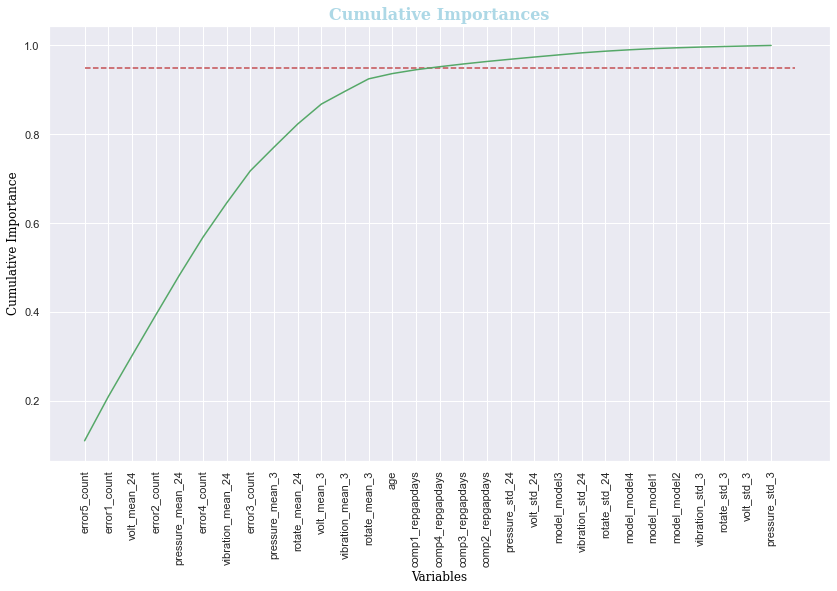

In [140]:

xvalues = list(range(len(list(impfeatdf.featureimportance))))

plt.figure(figsize=(14, 8))

# Make a line graph
plt.plot(xvalues, impfeatdf.cum_imp, 'g-')

# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin=0, xmax=len(impfeatdf.featureimportance), color = 'r', linestyles = 'dashed')

# Format x ticks and labels
plt.xticks(xvalues, impfeatdf.featurename, rotation = 'vertical')

# Axis labels and title
plt.xlabel('Variables', fontdict=labelfont)
plt.ylabel('Cumulative Importance', fontdict=labelfont)
plt.title('Cumulative Importances', fontdict=titlefont)

The following variables appear to be more important to the model as these variables could explain more than 90% of the variance in model: <br>

error1_count  <br>
error5_count  <br>
error2_count  <br>
error4_count  <br>
volt_mean_24  <br>
pressure_mean_24  <br>
vibration_mean_24  <br>
error3_count  <br>
pressure_mean_3  <br>
rotate_mean_24  <br>
volt_mean_3  <br>
vibration_mean_3  <br>

# Model Evaluation

In [141]:
# Get accuracy score
randomforest.score(X_test, y_test)

0.9989852248741679

In [142]:
# Create confusion matrix
y_pred = model.predict(X_test)
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[  284,     5,     0,     2,    24],
       [    1,   555,     0,     0,     3],
       [    1,     0,   206,     2,    10],
       [    2,     3,     0,   273,     5],
       [   14,     0,     0,     3, 72515]], dtype=int64)

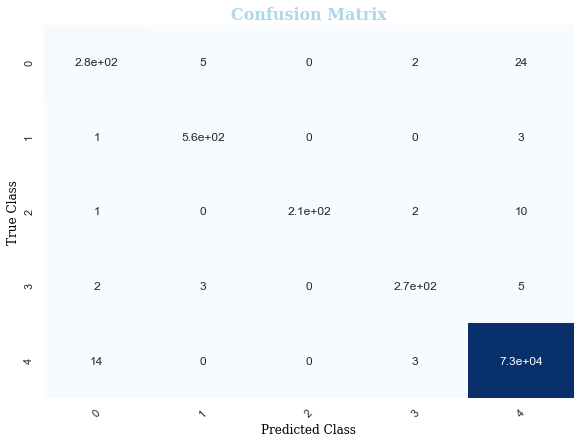

In [143]:
# Create pandas dataframe
dataframe = pd.DataFrame(matrix) #, index=class_names, columns=class_names)


# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues")
plt.title("Confusion Matrix") 
plt.tight_layout()
plt.xlabel("Predicted Class", fontdict=labelfont)
plt.ylabel("True Class", fontdict=labelfont)

plt.xticks(rotation=45)
plt.title("Confusion Matrix" , fontdict=titlefont)
plt.show()

In [144]:
# printing classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       comp1       0.94      0.90      0.92       315
       comp2       0.99      0.99      0.99       559
       comp3       1.00      0.94      0.97       219
       comp4       0.97      0.96      0.97       283
        none       1.00      1.00      1.00     72532

    accuracy                           1.00     73908
   macro avg       0.98      0.96      0.97     73908
weighted avg       1.00      1.00      1.00     73908



In [145]:
def fn_multiclass_metrics(actual_label, predicted_label):
    """
    function that takes acutal labels and predicted labels and returns
    accuracy, auc, precision, recall and f1 scores
    average = 'weighted' for multi class classification
    """
    accuracy = accuracy_score(actual_label, predicted_label)
    precision = precision_score(actual_label, predicted_label, average = 'weighted')
    recall = recall_score(actual_label, predicted_label, average = 'weighted')
    f1 = f1_score(actual_label, predicted_label, average = 'weighted')

    return (accuracy, precision, recall, f1)

In [146]:
acc, prec, recall, f1 = fn_multiclass_metrics(y_test, y_pred)

acc, prec, recall, f1


(0.9989852248741679,
 0.9989746911742967,
 0.9989852248741679,
 0.9989752956297505)

In preventive maintenance prediction, the most important metric to evaluate the model is recall, which conveys the actual number of failures predicted by the model. Here in the model built. it is around 99.8%. I suspect this could be due to large portion of failure = 'none'. I am sure, model could be further tweaked to nullify this bias with the help of domain experts. 

# Deployment

Create the model with best parameters obtained from  tuning.

Save the model using joblib module as a pickle.

Deploy the pickle on the server and use it for fitting new unseen data.

In [147]:
cwd = os.getcwd()
print(cwd)

projdir = os.path.dirname(cwd)
modeldir = os.path.join(projdir, 'Model')

# importing telemetry data

modelfile = os.path.join(modeldir, 'predictivemodel.pkl')



C:\Users\14802\OneDrive\Desktop\DSC 680-PROJECTS\Projects\Week1\Code


In [148]:
# Save the model as a pickle in a file 
joblib.dump(model, modelfile) 

['C:\\Users\\14802\\OneDrive\\Desktop\\DSC 680-PROJECTS\\Projects\\Week1\\Model\\predictivemodel.pkl']

In [149]:
# Load the model from the file 
tunedmodel_from_joblib = joblib.load(modelfile) 


In [150]:
# Fitting deployed model on new data ( assume here X_train and y_train are new unseen features and targets)
deployed_model = tunedmodel_from_joblib.fit(X_train, y_train)

# Conslusion

The accuracy of the model appears to be around 99 percent, which is incredible. I am confident that the model can be improved further by reducing bias and other factors. Another way to improve is to develop and train the model using the essential feature variables listed above.Building a predictive model for preventive maintenance, like any other predictive modeling, necessitates a great deal of domain knowledge and the creation of several feature variables. In this model, I used rolling mean for the last 24 hours and last 3 hours for each 3 hour window to produce telemetry feature variables. We may need to explore longer windows for these rolling computations at times. However, feature engineering is a large task, and data scientists in this preventative maintenance use case will need some help from domain experts.